<a href="https://colab.research.google.com/github/var2019/MIS-5400/blob/master/Copy_of_Group_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

import matplotlib as mpl
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
plt.rc('figure', titlesize=20)

import warnings
warnings.filterwarnings("ignore", category=mpl.cbook.mplDeprecation)

In [ ]:
import os

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=600):
    path = os.path.join('/content/drive/Shared drives/BioFire/Images', fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

---
# Get data
#### Data manipulation on original dataset

In [ ]:
rp_data = pd.read_csv('/content/drive/Shared drives/BioFire/Data/RP_MDATA_20200415.csv')

# Filter for PouchTitle starts with R and drop column
rp_data = rp_data[rp_data.PouchTitle.str.startswith("R")].drop(columns = 'PouchTitle')

# Remove Bocavirus, Bordetella parapertussis
rp_data = rp_data[~rp_data.TargetName.isin(['Bocavirus', 'Bordetella parapertussis (IS1001)'])]

# Remove columns with one value (Country)
rp_data = rp_data.drop(columns = 'Country')

# Add column for StartTime date and drop StartTime
rp_data['Date'] = pd.to_datetime(rp_data['StartTime']).dt.date
rp_data = rp_data.drop(columns = 'StartTime')

# Rename RunDataID to ID and convert ID to factors
if 'RunDataID' in rp_data.columns:
    rp_data = rp_data.rename(columns = {"RunDataID": "ID"})
elif 'RunDataId' in rp_data.columns:
    rp_data = rp_data.rename(columns = {"RunDataId": "ID"})
rp_data['ID'] = pd.factorize(rp_data['ID'])[0] + 1

# Remove rows where FlaggedAsValidation = 0 and drop column
rp_data = rp_data[rp_data.FlaggedAsValidation == 0].drop(columns = 'FlaggedAsValidation')

# Remove currently unneeded columns and generate unique rows
rp_data = rp_data.drop(columns = ['TargetResult','InstrumentSerialNumber','InstitutionID','AssayName','AssayResult','InstrumentVersion']).drop_duplicates().sort_values(by=['Date','ID'])

# Reorder columns
rp_data = rp_data[['ID','Date','ResultType','TargetName','Region','ZipCode']]

# Write to CSV
rp_data.to_csv('/content/drive/Shared drives/BioFire/Data/Subsets/Respiratory.csv', index=False)

---
# Total Utilization Rate

### Total Tests Per Day

In [ ]:
# If CSV is already created
rp_data = pd.read_csv('/content/drive/Shared drives/BioFire/Data/Subsets/Respiratory.csv')
rp_data.Date = pd.to_datetime(rp_data.Date)

In [ ]:
totalUtilizationRate = rp_data.copy()

# Count number of tests per day
totalUtilizationRate['rollingAverage'] = totalUtilizationRate.Date.map(totalUtilizationRate.groupby('Date').ID.nunique())

# Reindex using Date
totalUtilizationRate = totalUtilizationRate.set_index(totalUtilizationRate.Date)

# Drop unneeded columns and duplicates
totalUtilizationRate = totalUtilizationRate.drop(columns = ['ID','ResultType','TargetName','Region','ZipCode']).drop_duplicates()

# Fill in missing dates
missingDates = pd.date_range(min(totalUtilizationRate.Date), max(totalUtilizationRate.Date))

# Reindex using missingDates and fill with 0s
totalUtilizationRate = totalUtilizationRate.reindex(missingDates, fill_value = 0).drop(columns = 'Date')

# 21 day rolling average
totalUtilizationRate = totalUtilizationRate.rolling(window = 21, center=True, min_periods=1).mean()

# Write to CSV
totalUtilizationRate.to_csv('/content/drive/Shared drives/BioFire/Data/Subsets/totalUtilizationRate.csv', index=False)

### Positive Tests Per Day

In [ ]:
positives = rp_data.copy()

# Filter for ResultType = organism
positives = positives[positives.ResultType == 'organism'].drop(columns = ['ResultType']).drop_duplicates()

# Count number of positive tests per day grouped by TargetName
positives = pd.crosstab(index = positives.Date, columns = positives.TargetName)

# Merge Bordetella pertussis and Bordetella pertussis (ptxP)
if 'Bordetella pertussis (ptxP)' in positives.columns:
    positives['Bordetella pertussis'] = positives['Bordetella pertussis'] + positives['Bordetella pertussis (ptxP)']
    positives = positives.drop(columns = 'Bordetella pertussis (ptxP)')

# Merge Chlamydia pneumoniae and Chlamydophila pneumoniae
if 'Chlamydia pneumoniae' in positives.columns:
    positives['Chlamydophila pneumoniae'] = positives['Chlamydia pneumoniae'] + positives['Chlamydophila pneumoniae']
    positives = positives.drop(columns = 'Chlamydophila pneumoniae')

# Merge Coronavirus OC43 and Coronavirus OC43 (RP)
if 'Coronavirus OC43 (RP)' in positives.columns:
    positives['Coronavirus OC43'] = positives['Coronavirus OC43'] + positives['Coronavirus OC43 (RP)']
    positives = positives.drop(columns = 'Coronavirus OC43 (RP)')

# Fill in missing dates
missingDates = pd.date_range(min(positives.index), max(positives.index))
positives = positives.reindex(missingDates, fill_value = 0)

# 21 day rolling average
positives = positives.rolling(window = 21, center=True, min_periods=1).mean()

# Write to CSV
positives.to_csv('/content/drive/Shared drives/BioFire/Data/Subsets/positives.csv', index=False)

### Negative Tests Per Day

In [ ]:
# IDs for positive tests
positiveIDs = rp_data.copy()
positiveIDs = positiveIDs[positiveIDs.ResultType == 'organism'].ID.drop_duplicates().to_list()

negatives = rp_data.copy()

# Remove IDs that are positives
negatives = negatives[~negatives.ID.isin(positiveIDs)]

# Count number of tests per day for each unique ID
negatives['rollingAverage'] = negatives.Date.map(negatives.groupby('Date').ID.nunique())

# Reindex with Date
negatives = negatives.set_index(negatives.Date)

# Drop columns and duplicates
negatives = negatives.drop(columns = ['ID','ResultType','TargetName','Region','ZipCode']).drop_duplicates()

# Fill in missing dates
missingDates = pd.date_range(min(negatives.Date), max(negatives.Date))
negatives = negatives.reindex(missingDates, fill_value = 0).drop(columns = 'Date')

# Calculate rolling average
negatives = negatives.rolling(window = 21, center=True, min_periods=1).mean()

# Write to CSV
negatives.to_csv('/content/drive/Shared drives/BioFire/Data/Subsets/negatives.csv', index=False)

### Graphs

Saving figure TUR_Pathogen_Counts


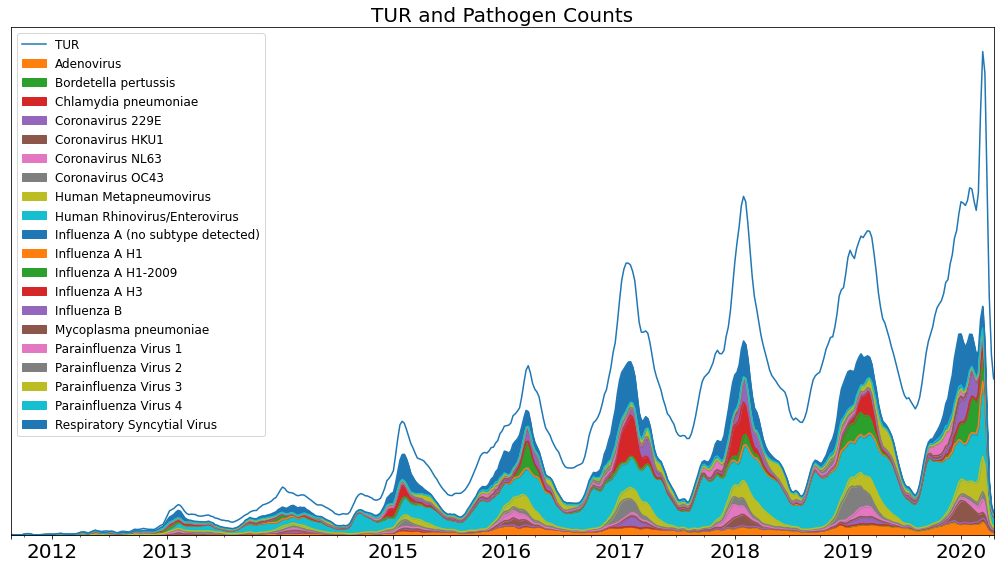

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

# plots
totalUtilizationRate.resample('W').mean().rollingAverage.plot(label='TUR')
positives.resample('W').mean().plot.area(ax=ax)

# Title
ax.set_title('TUR and Pathogen Counts', fontdict={'fontsize': 20})

# Remove legend title
plt.legend(title=False)

# Hide y axis labels
ax.axes.get_yaxis().set_visible(False)

save_fig("TUR_Pathogen_Counts")

plt.show()

---
# Percent Detection

$\mbox{Percent Detection} = \dfrac{\mbox{Number Of Tests}}{TUR}$

In [ ]:
positivePercentDetection = positives.divide(pd.Series(totalUtilizationRate.rollingAverage), axis=0) * 100
negativePercentDetection = negatives.divide(pd.Series(totalUtilizationRate.rollingAverage), axis=0) * 100

## Graphs

Saving figure Pathogen_Percent_Detection


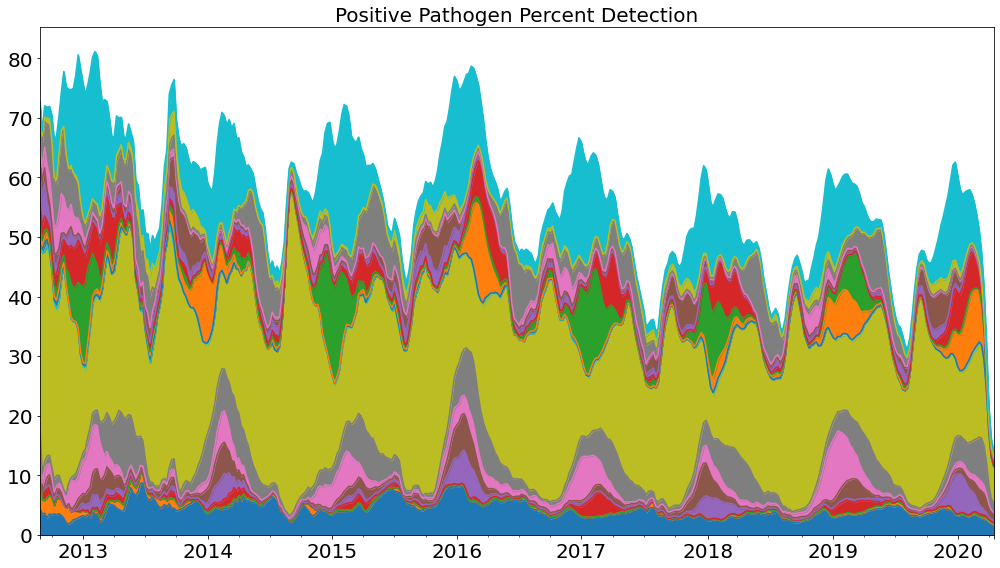

In [ ]:
positivePercentDetection.resample('W').mean().loc['2012-09-01':].plot.area(figsize=(14, 8), legend=False)

# Title
plt.title('Positive Pathogen Percent Detection', fontdict={'fontsize': 20})

save_fig("Pathogen_Percent_Detection")

plt.show()

---
# Standardizing

Create a z-score:

$TURN = \dfrac{TUR - TUR_\mbox{Centered Window Mean}}{TUR_\mbox{Centered Window Standard Deviation}}$

In [ ]:
totalUtilizationRate = totalUtilizationRate.loc['2013-01-01':]
turn = ((totalUtilizationRate - totalUtilizationRate.rolling(window = 730, center=True, min_periods=1).mean()) / totalUtilizationRate.rolling(window = 730, center=True, min_periods=1).std()).dropna()
turn_800 = ((totalUtilizationRate - totalUtilizationRate.rolling(window = 800, center=True, min_periods=1).mean()) / totalUtilizationRate.rolling(window = 800, center=True, min_periods=1).std()).dropna()

Saving figure TURN_Different_Standardizing_Dates


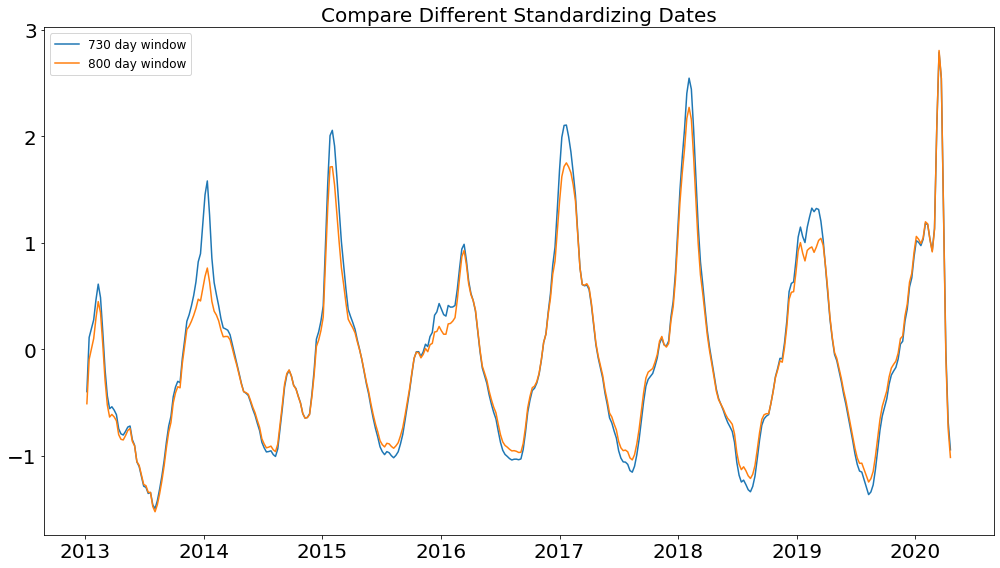

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(turn.resample('W').mean(), label='730 day window')
plt.plot(turn_800.resample('W').mean(), label='800 day window')
plt.legend(loc=2)
plt.title('Compare Different Standardizing Dates', fontdict={'fontsize': 20})
save_fig("TURN_Different_Standardizing_Dates")
plt.show()

Saving figure TURN_Moving_Average


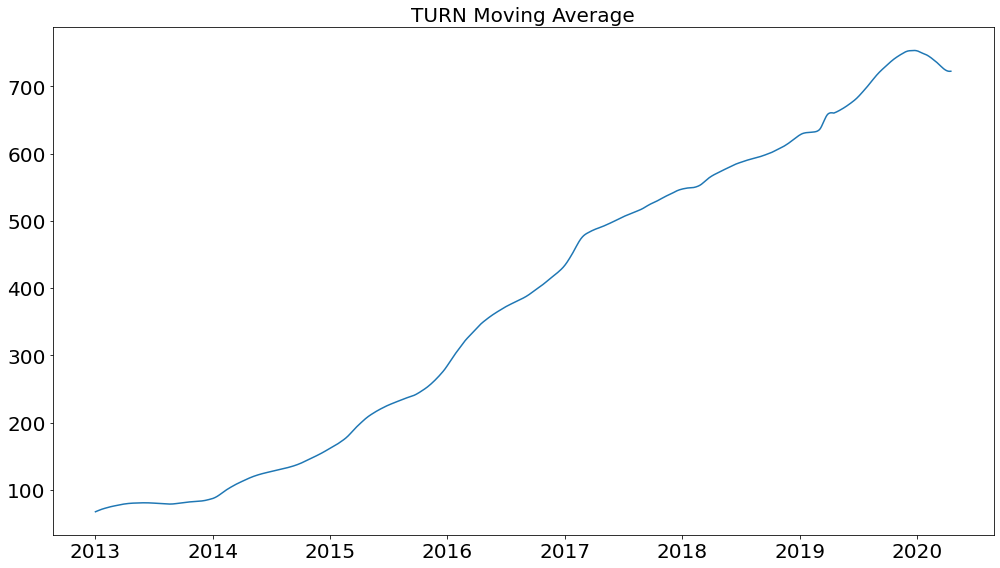

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(totalUtilizationRate.rolling(window = 730, center=True, min_periods=1).mean())
plt.title('TURN Moving Average', fontdict={'fontsize': 20})
save_fig("TURN_Moving_Average")
plt.show()

Saving figure TURN_Standard_Deviation


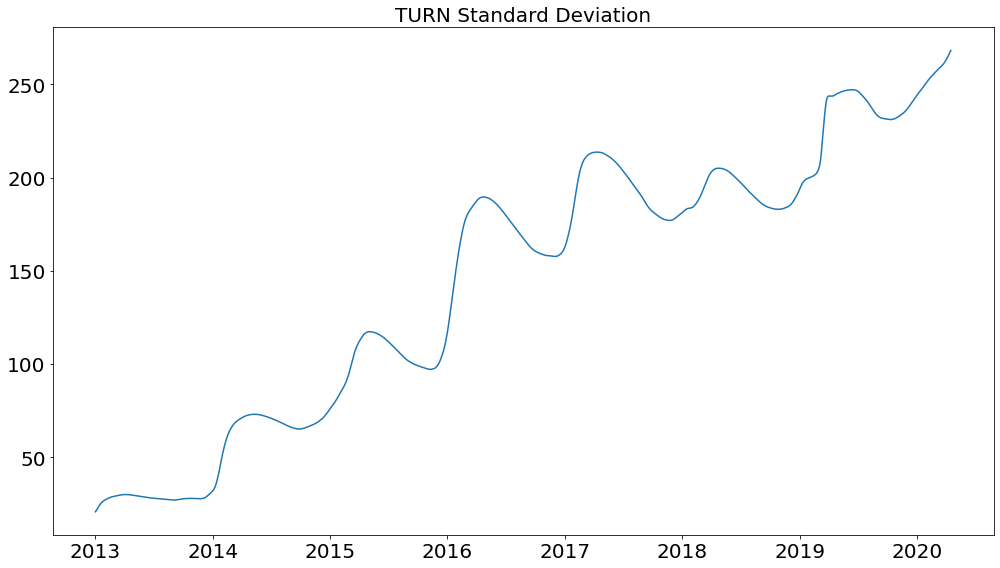

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(totalUtilizationRate.rolling(window = 730, center=True, min_periods=1).std())
plt.title('TURN Standard Deviation', fontdict={'fontsize': 20})
save_fig("TURN_Standard_Deviation")
plt.show()

### Smoothed moving standard deviation


In [ ]:
movingsd = totalUtilizationRate.rolling(window = 730, center=True, min_periods=1).std()
smoothed_standarddeviation = movingsd.rolling(window = 730, center=True, min_periods=1).mean()

Saving figure TURN_Standard_Deviation_Smoothed


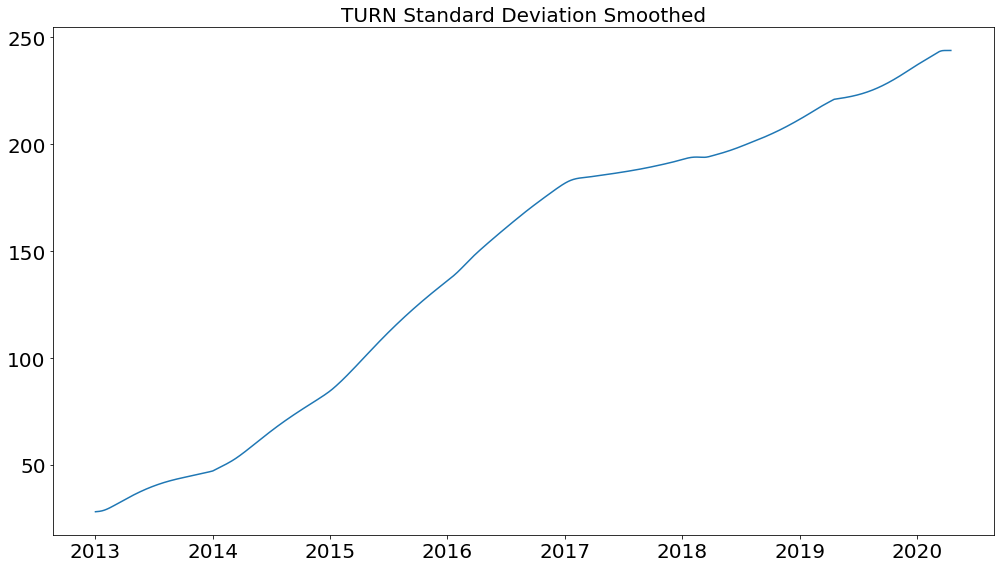

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(smoothed_standarddeviation)
plt.title('TURN Standard Deviation Smoothed', fontdict={'fontsize': 20})
save_fig("TURN_Standard_Deviation_Smoothed")
plt.show()

## Graphical comparison of smoothed Standard deviation and non smoothed

In [ ]:
turn_smoothsd = ((totalUtilizationRate - totalUtilizationRate.rolling(window = 730, center=True, min_periods=1).mean()) / smoothed_standarddeviation).dropna()

Saving figure TURN_Standard_Deviation_Comparison


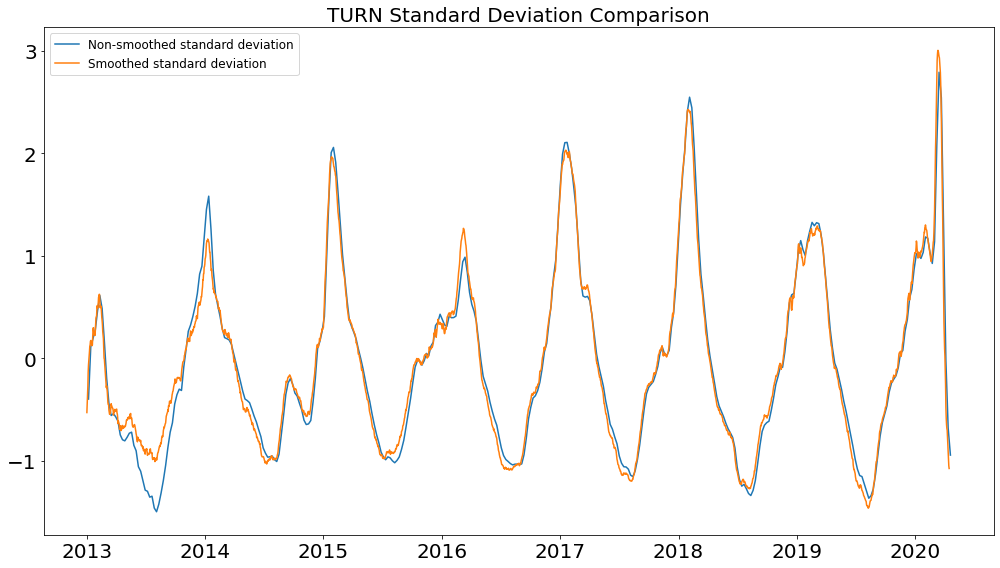

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(turn['rollingAverage'].resample('W').mean(), label='Non-smoothed standard deviation')
plt.plot(turn_smoothsd, label='Smoothed standard deviation')
plt.legend(loc=2)
plt.title('TURN Standard Deviation Comparison', fontdict={'fontsize': 20})
save_fig("TURN_Standard_Deviation_Comparison")
plt.show()

### Shift TURN to 100% scale

In [ ]:
turn['on100'] = st.norm.cdf(turn['rollingAverage']) * 100

# Write to CSV
turn.rename(columns = {"on100": "TURN"}).TURN.to_csv('/content/drive/Shared drives/BioFire/Data/Subsets/turn.csv')

Saving figure TURN_Percentage_100_Scale


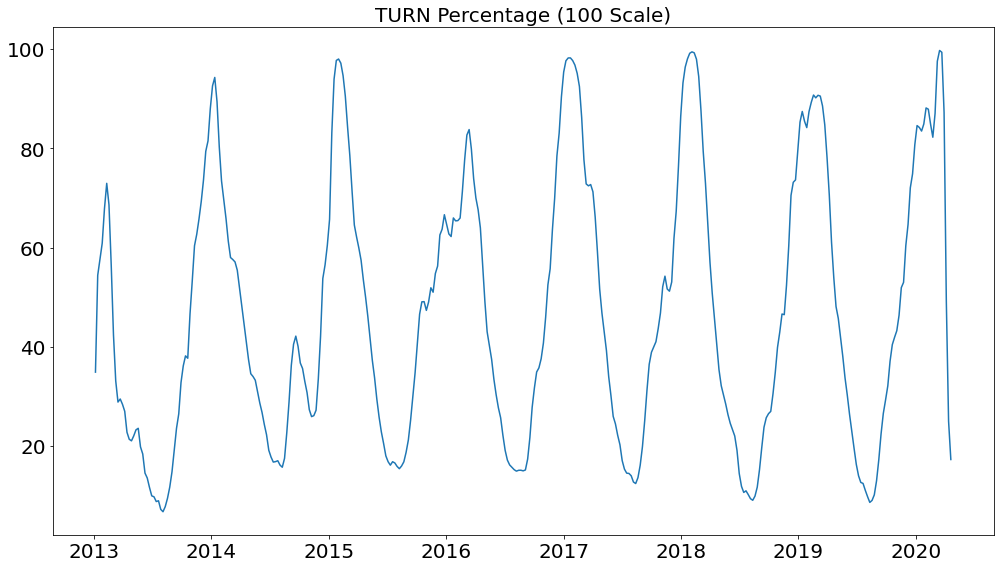

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(turn.on100.resample('W').mean())
plt.title('TURN Percentage (100 Scale)', fontdict={'fontsize': 20})
save_fig("TURN_Percentage_100_Scale")
plt.show()

### Correlation with Group 1

In [ ]:
group1_turn = pd.read_csv('/content/drive/Shared drives/BioFire/Data/group1_turn.csv')
group1_turn = pd.DataFrame(data=group1_turn, columns=['epidate', 'TURN'])
group1_turn.epidate = pd.to_datetime(group1_turn.epidate)

Saving figure TURN_Comparison_Group1


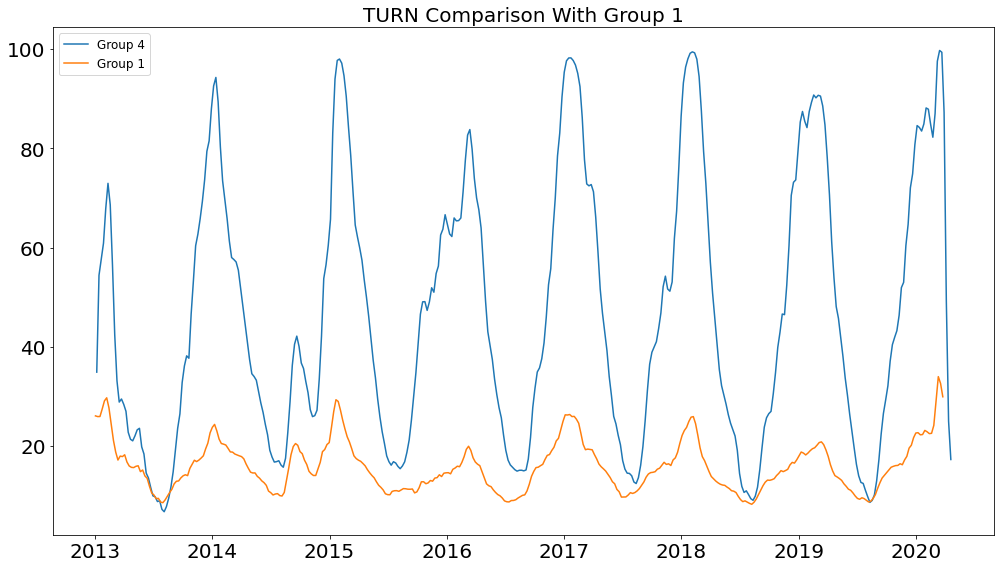

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(turn.on100.resample('W').mean(), label='Group 4')
plt.plot(group1_turn.epidate, group1_turn.TURN, label='Group 1')
plt.legend(loc=2)
plt.title('TURN Comparison With Group 1', fontdict={'fontsize': 20})
save_fig("TURN_Comparison_Group1")
plt.show()

### Turning Group 1 Turn to a zscore then then on a 0-100 scale. Because it has been normalized a moving average is not used


In [ ]:
group1_turn['zscore'] = ((group1_turn['TURN'] - group1_turn['TURN'].mean()) / group1_turn['TURN'].std()).dropna()
group1_turn['on100'] = st.norm.cdf(group1_turn['zscore']) * 100

### Group 1 Turn and Group 4 Turn Compared

Saving figure TURN_Comparison_Group1_100_Scale


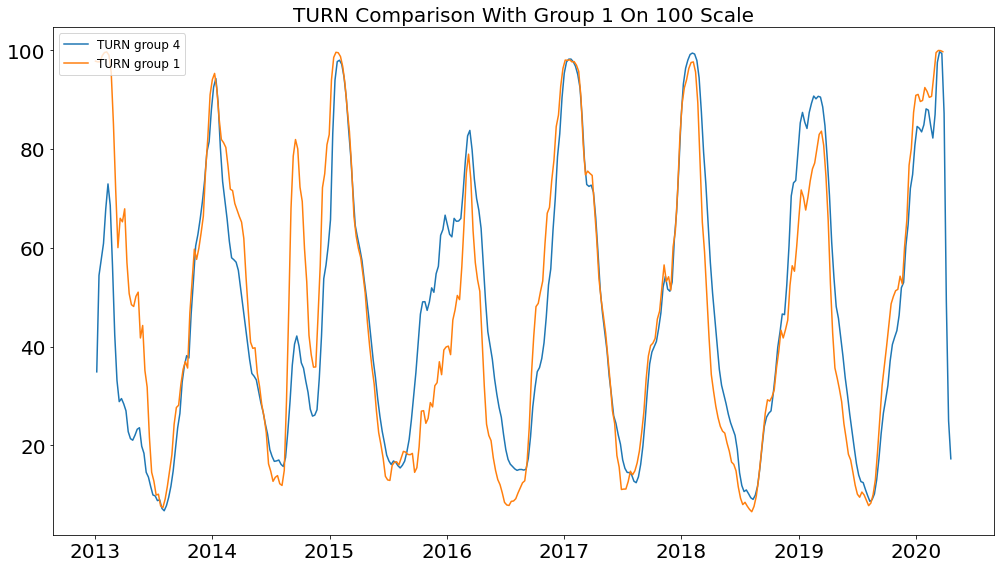

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(turn.on100.resample('W').mean(), label='TURN group 4')
plt.plot(group1_turn.epidate, group1_turn.on100, label='TURN group 1')
plt.legend(loc=2)
plt.title('TURN Comparison With Group 1 On 100 Scale', fontdict={'fontsize': 20})
save_fig("TURN_Comparison_Group1_100_Scale")
plt.show()

In [ ]:
#correlation with group 1 
modified = turn.reset_index()
modified.rename(columns={"index": "epidate"}, inplace=True)

merged = group1_turn.merge(modified, left_on='epidate', right_on='epidate')
merged.corr(method ='pearson') 

TURN    zscore   on100_x  rollingAverage   on100_y
TURN            1.000000  1.000000  0.974626        0.879887  0.861421
zscore          1.000000  1.000000  0.974626        0.879887  0.861421
on100_x         0.974626  0.974626  1.000000        0.873922  0.882328
rollingAverage  0.879887  0.879887  0.873922        1.000000  0.983190
on100_y         0.861421  0.861421  0.882328        0.983190  1.000000

In [ ]:
df = turn.on100.resample('W').mean().reset_index()
df.on100.corr(group1_turn.on100, method='pearson')

0.8838481953852725

## TURN and Percent Detections

In [ ]:
combined = turn.copy()
combined['Negatives'] = negativePercentDetection.loc['2013-01-01':].mul(turn.on100.loc['2013-01-01':], axis=0) / 100
combined.rename(columns={"rollingAverage": "TURN"}, inplace=True)
positivePercentDetection_mul_turn = positivePercentDetection.loc['2013-01-01':].mul(turn.on100.loc['2013-01-01':], axis=0) / 100
combined = combined.merge(positivePercentDetection_mul_turn, how='outer', left_index=True, right_index=True, copy=False)
combined.to_csv('/content/drive/Shared drives/BioFire/Data/Subsets/Standardized.csv')

Saving figure TURN_Percent_Detections_All


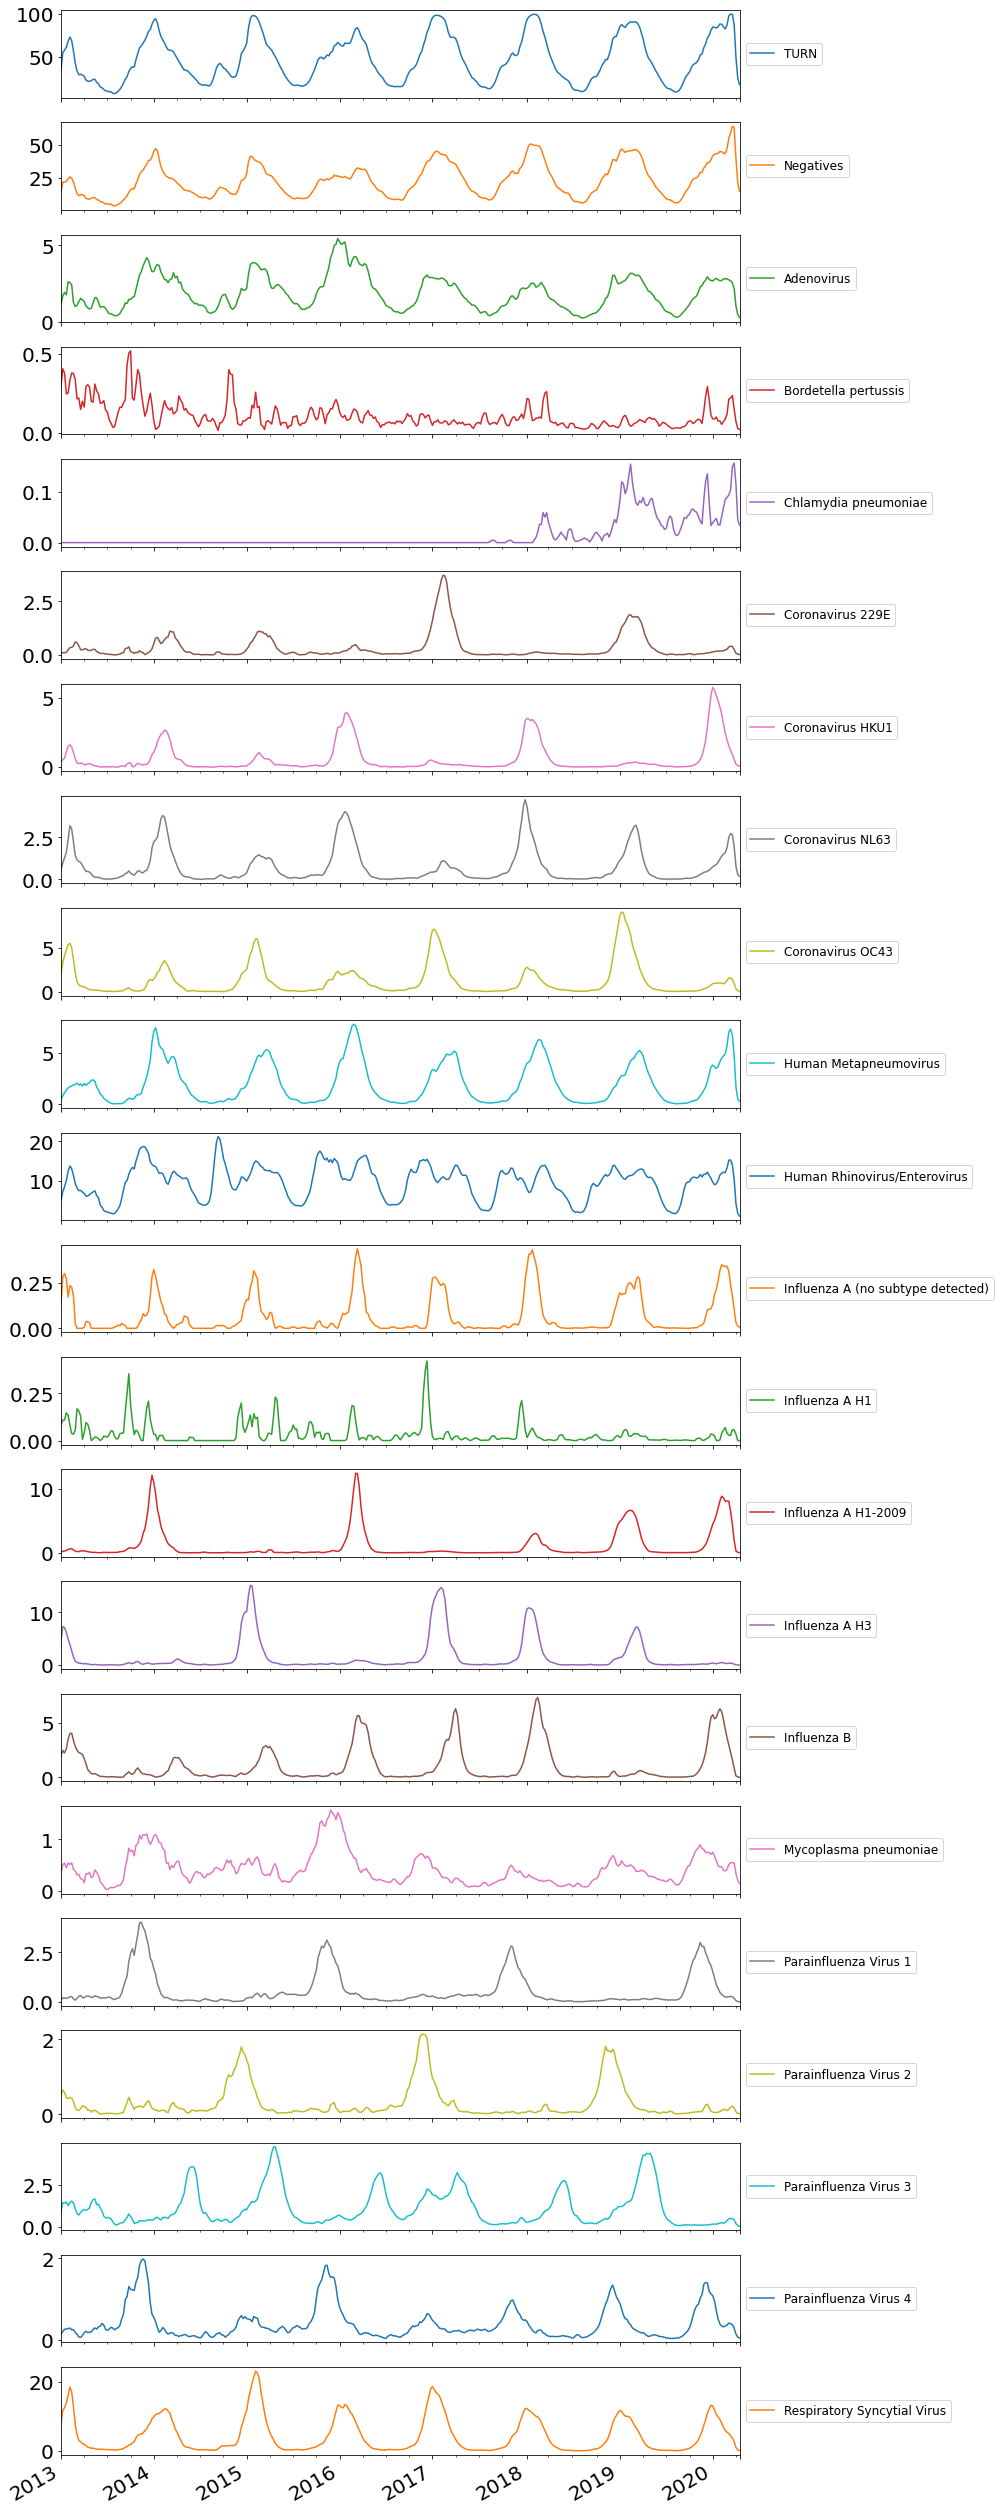

In [ ]:
df = combined.loc[:, 'on100':].resample('W').mean().copy()
df.rename(columns={"on100": "TURN"}, inplace=True)

df.plot(figsize=(14,35), subplots=True)
[ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) for ax in plt.gcf().axes]

save_fig("TURN_Percent_Detections_All")
plt.show()

Saving figure TURN_Percent_Detections_on100


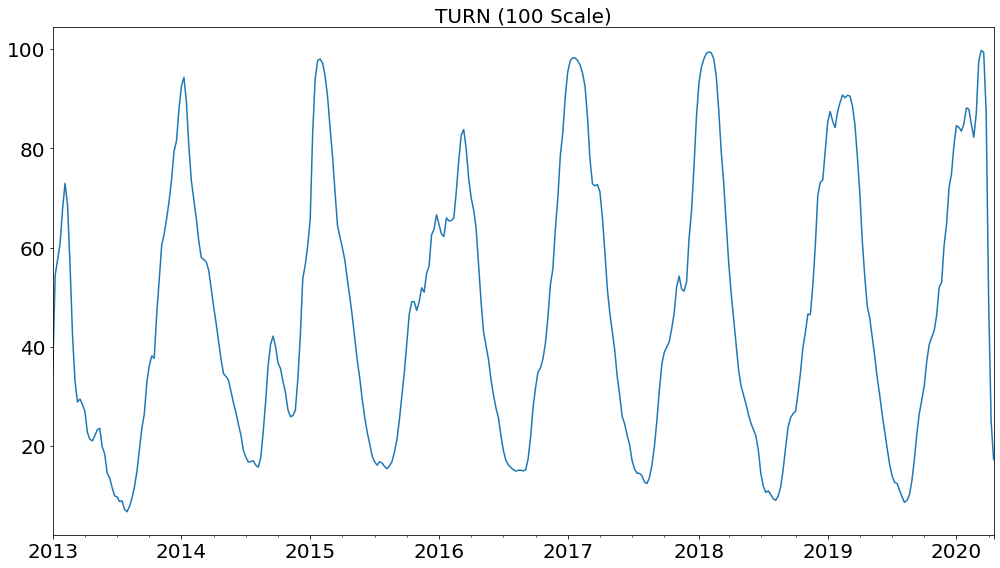

Saving figure TURN_Percent_Detections_Negatives


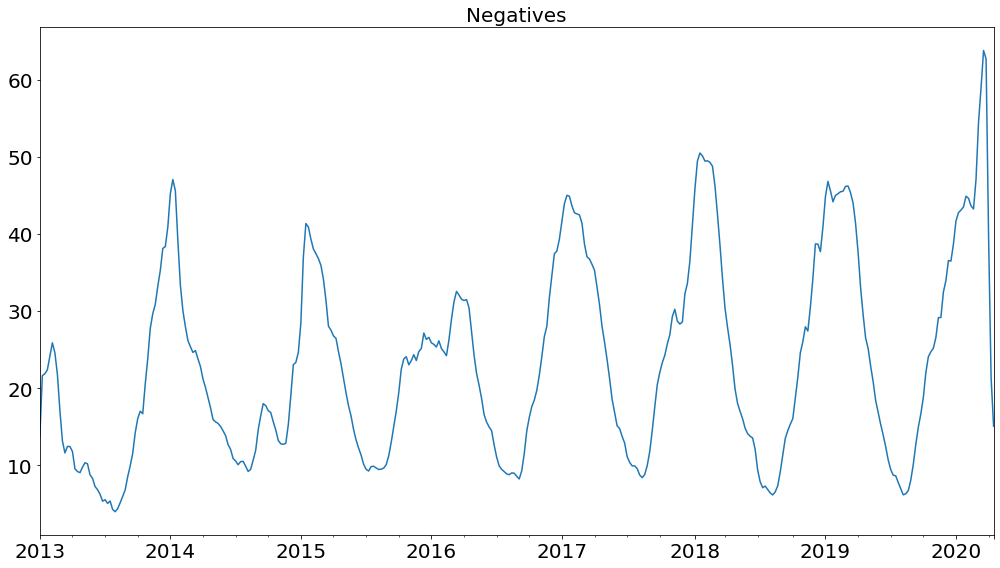

Saving figure TURN_Percent_Detections_Adenovirus


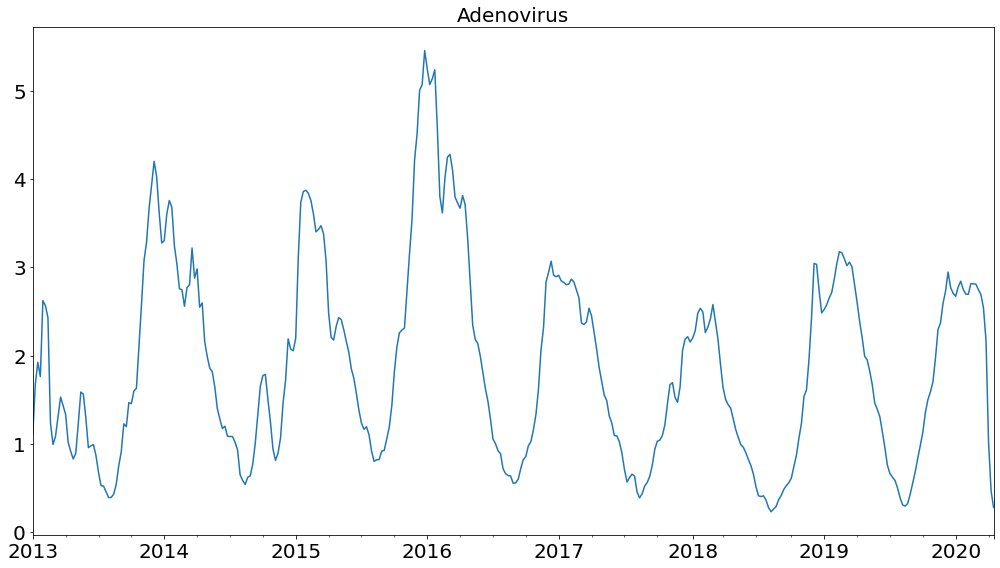

Saving figure TURN_Percent_Detections_Bordetella pertussis


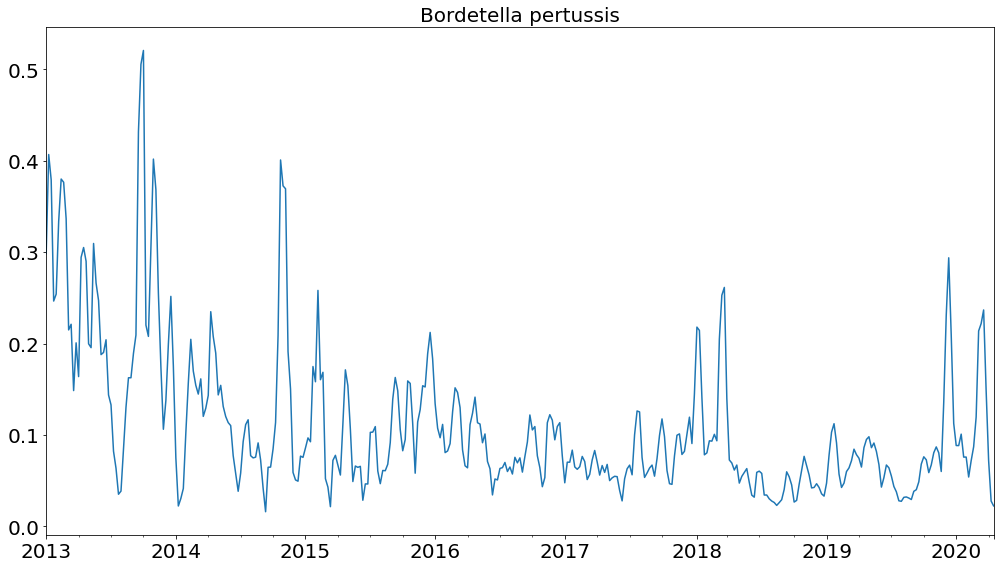

Saving figure TURN_Percent_Detections_Chlamydia pneumoniae


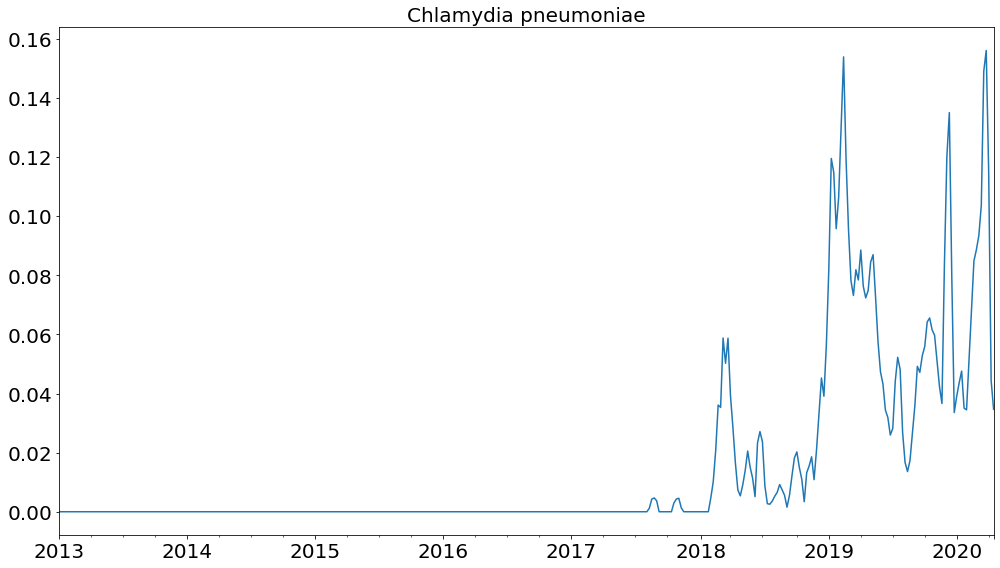

Saving figure TURN_Percent_Detections_Coronavirus 229E


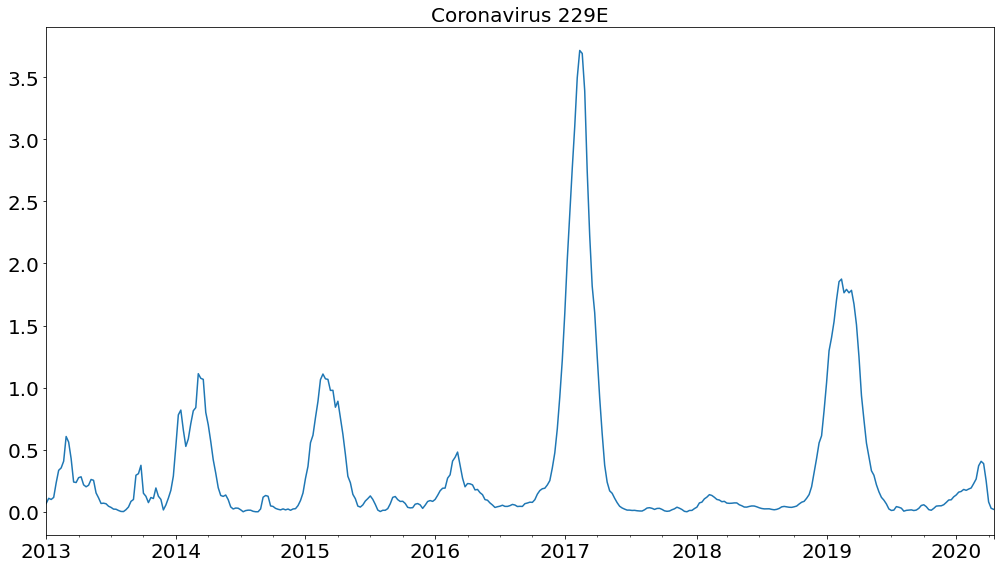

Saving figure TURN_Percent_Detections_Coronavirus HKU1


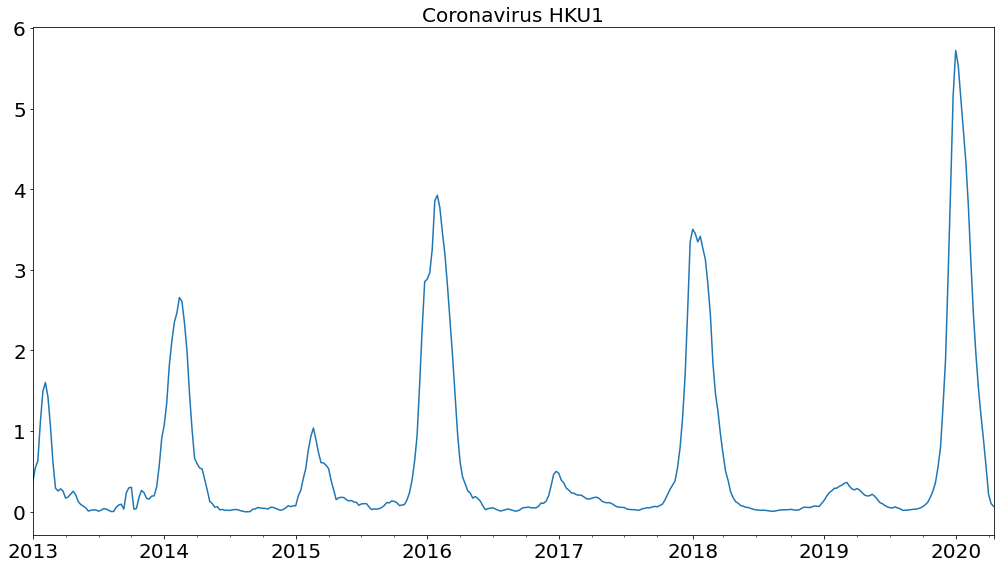

Saving figure TURN_Percent_Detections_Coronavirus NL63


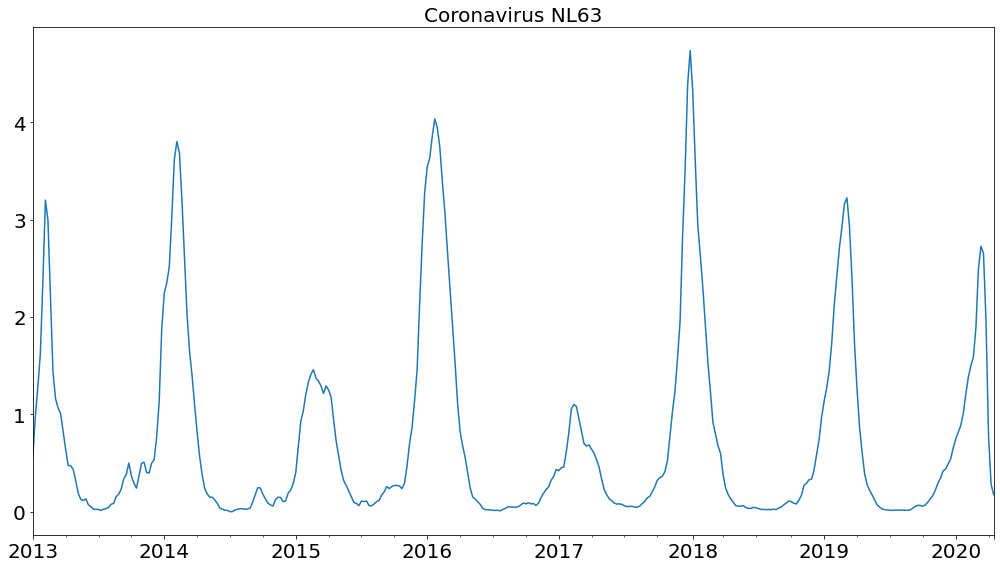

Saving figure TURN_Percent_Detections_Coronavirus OC43


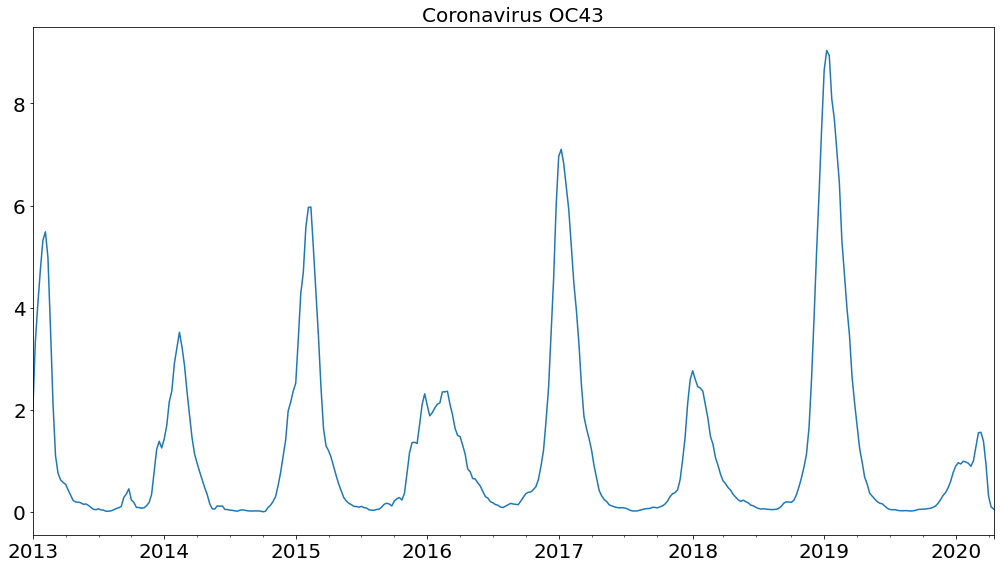

Saving figure TURN_Percent_Detections_Human Metapneumovirus


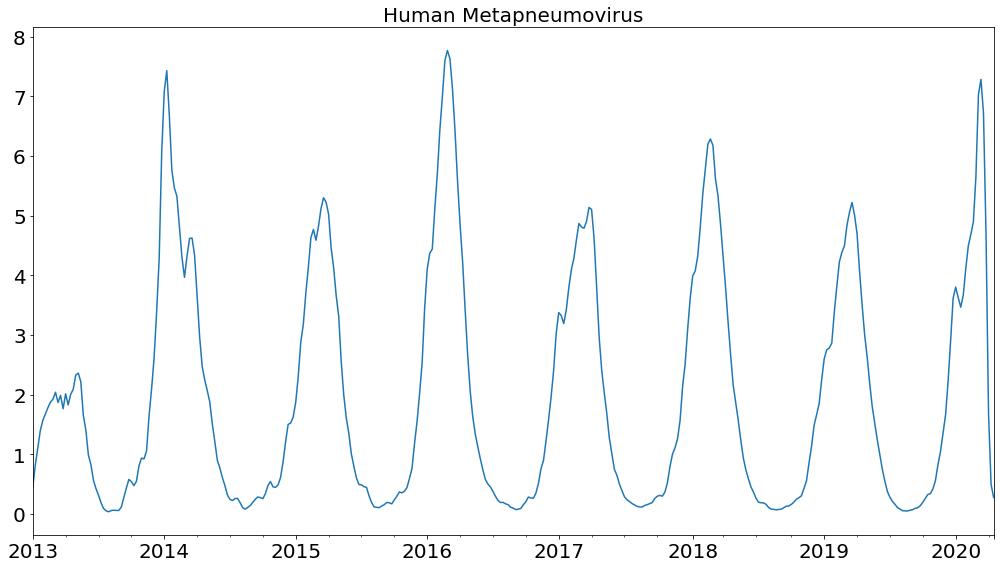

Saving figure TURN_Percent_Detections_HRV


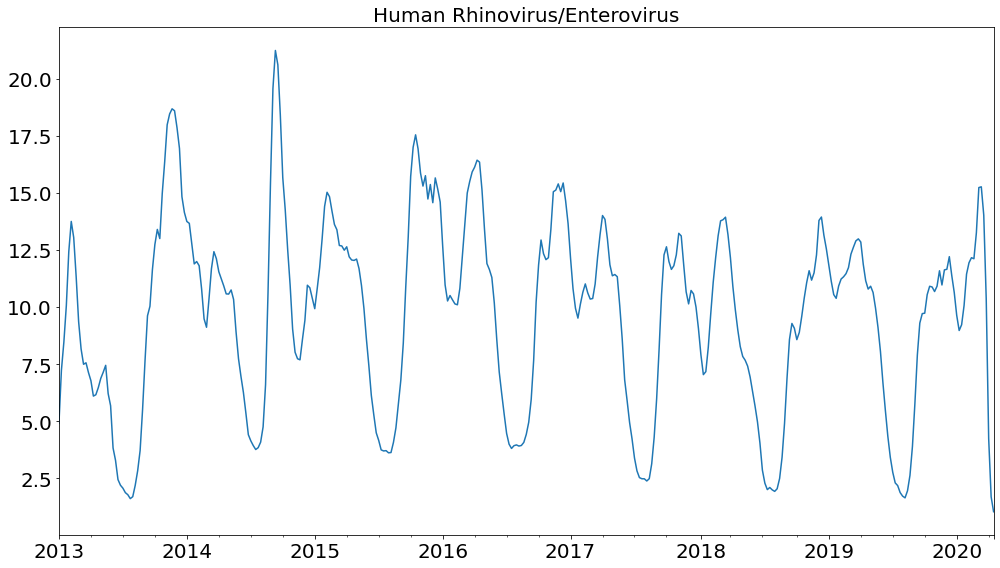

Saving figure TURN_Percent_Detections_Influenza A (no subtype detected)


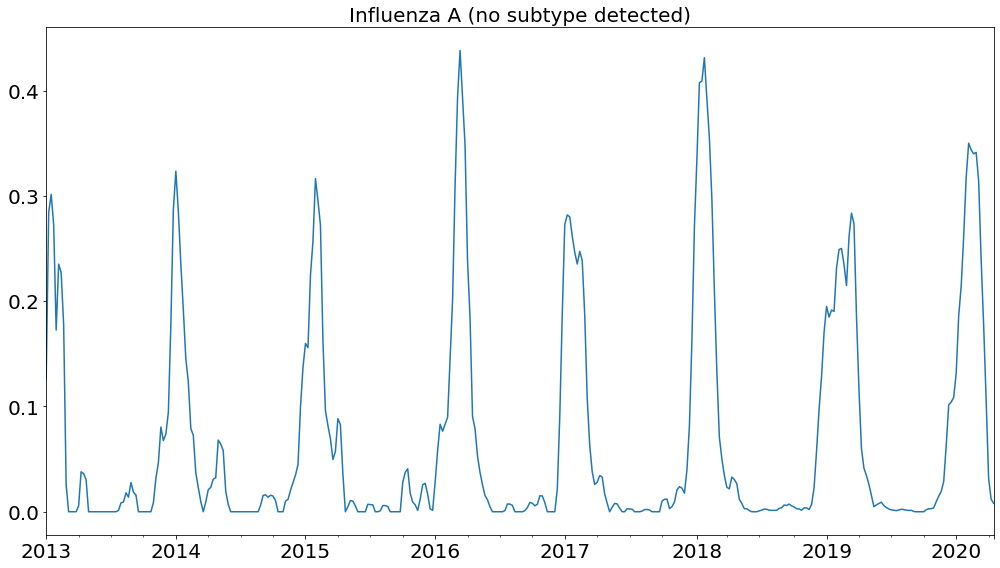

Saving figure TURN_Percent_Detections_Influenza A H1


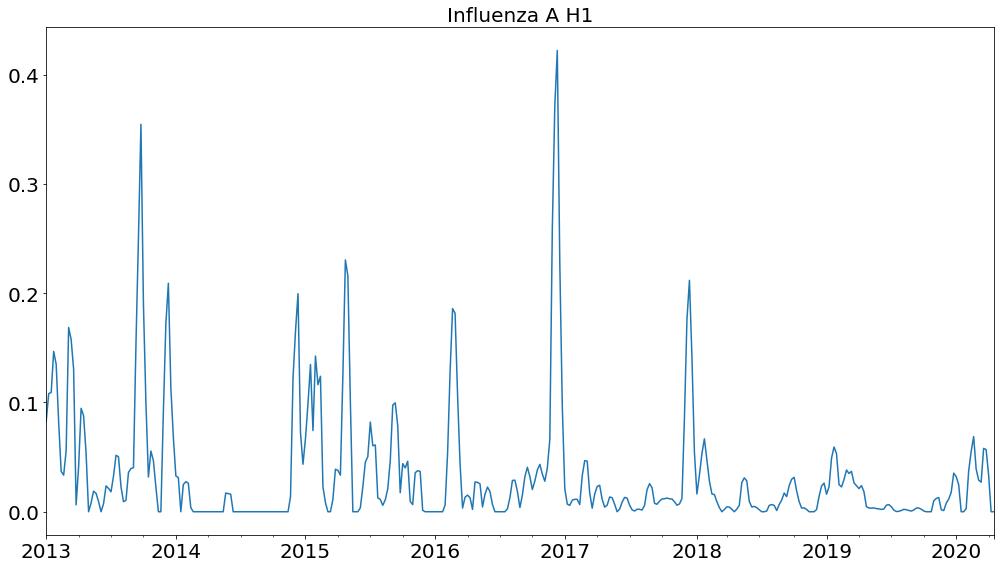

Saving figure TURN_Percent_Detections_Influenza A H1-2009


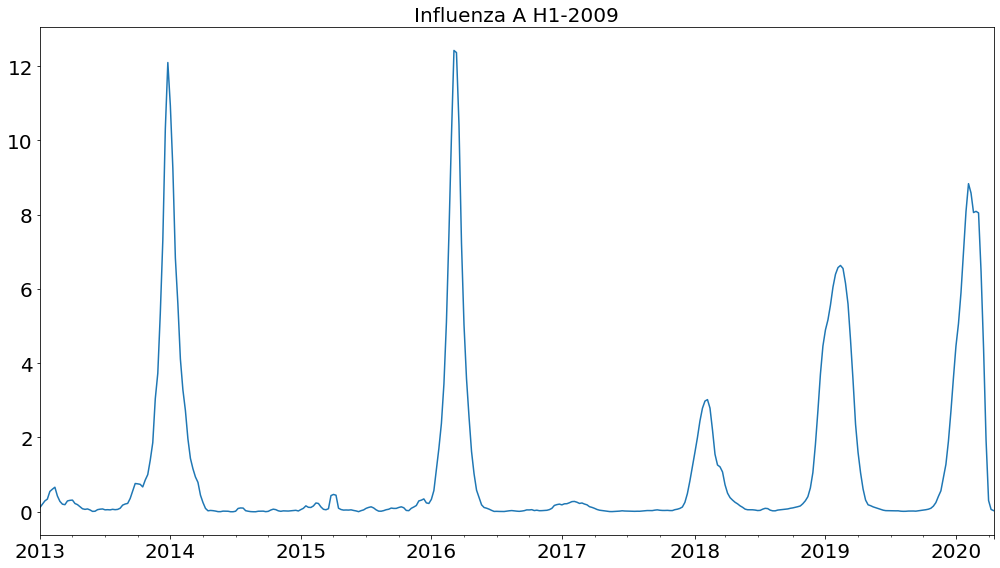

Saving figure TURN_Percent_Detections_Influenza A H3


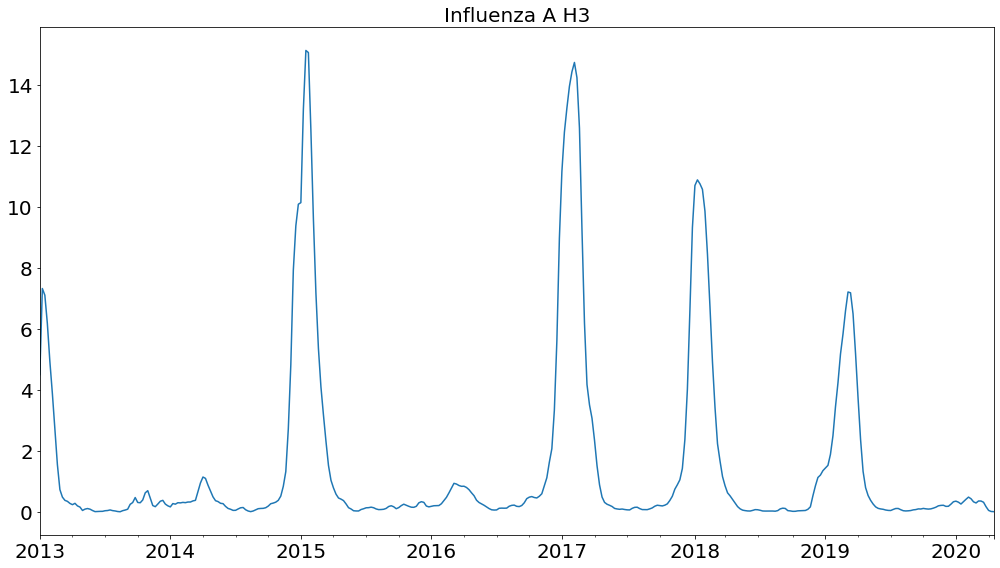

Saving figure TURN_Percent_Detections_Influenza B


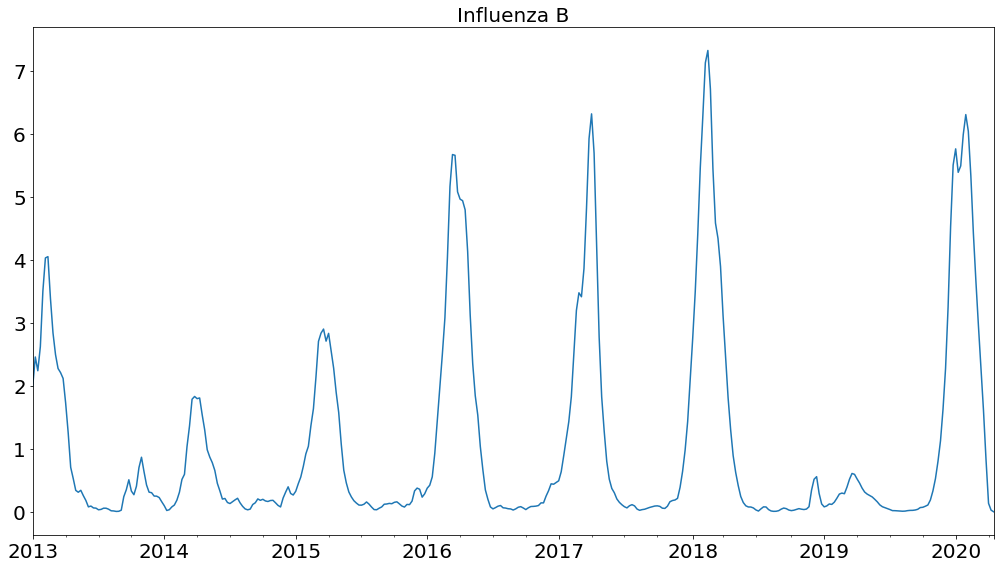

Saving figure TURN_Percent_Detections_Mycoplasma pneumoniae


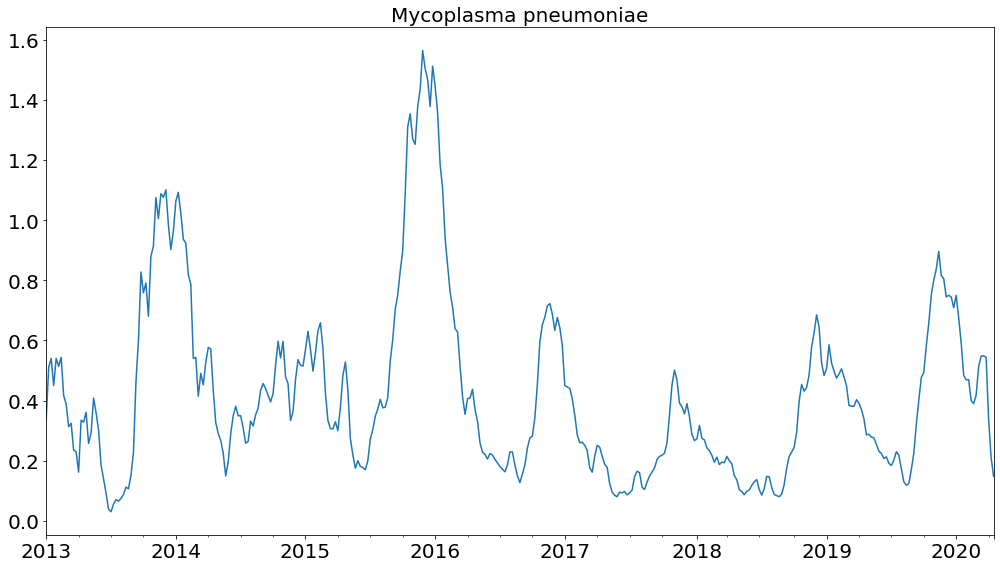

Saving figure TURN_Percent_Detections_Parainfluenza Virus 1


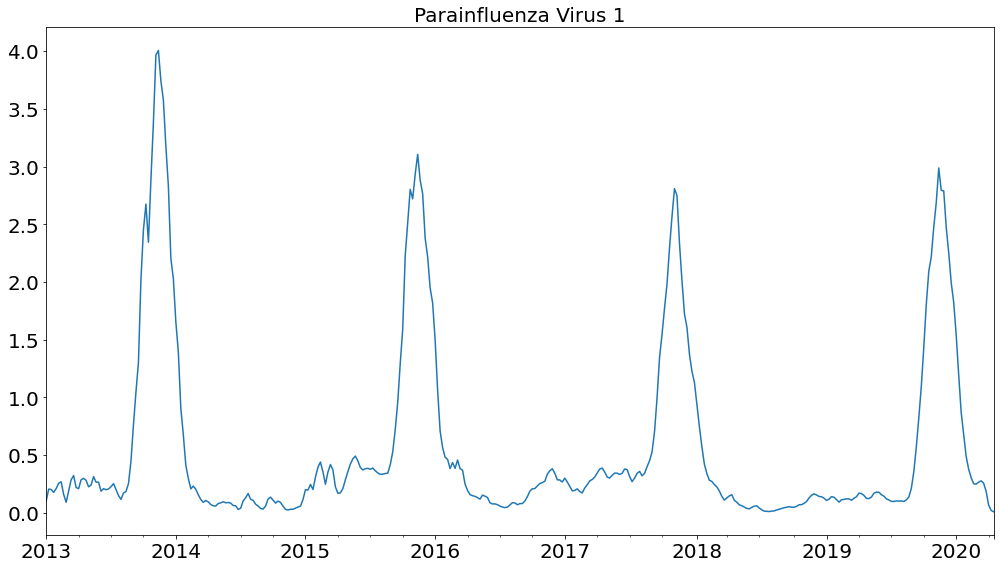

Saving figure TURN_Percent_Detections_Parainfluenza Virus 2


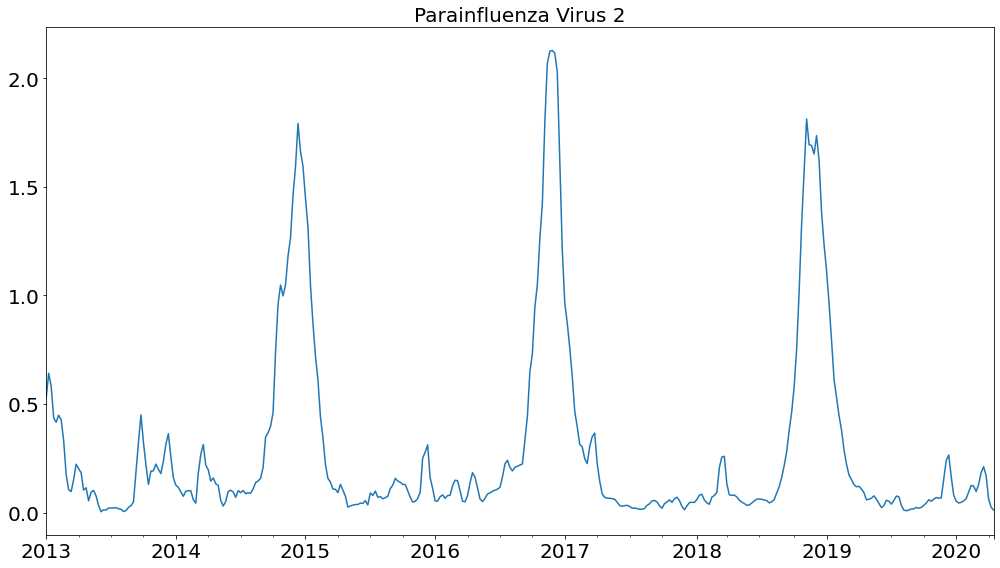

Saving figure TURN_Percent_Detections_Parainfluenza Virus 3


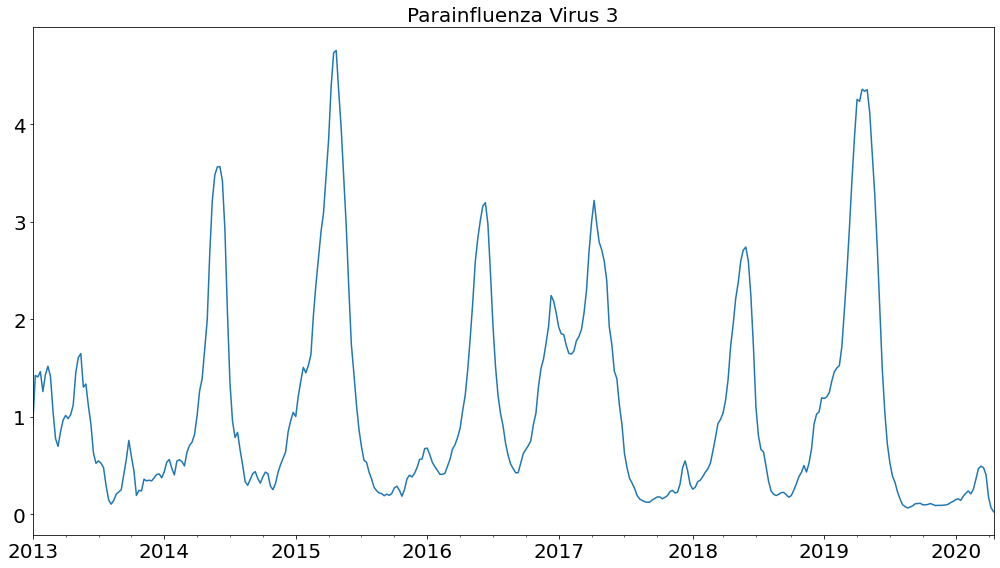

Saving figure TURN_Percent_Detections_Parainfluenza Virus 4


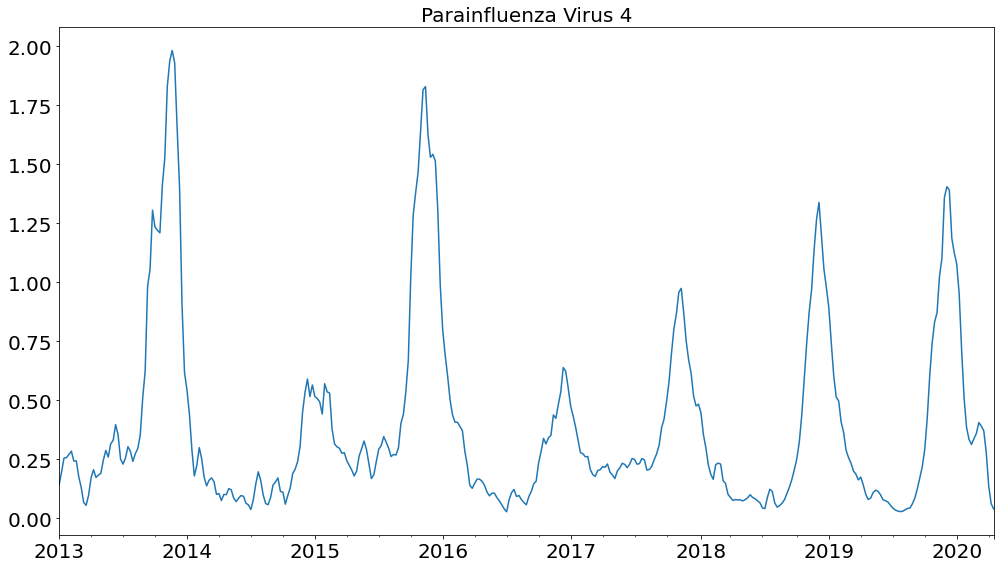

Saving figure TURN_Percent_Detections_Respiratory Syncytial Virus


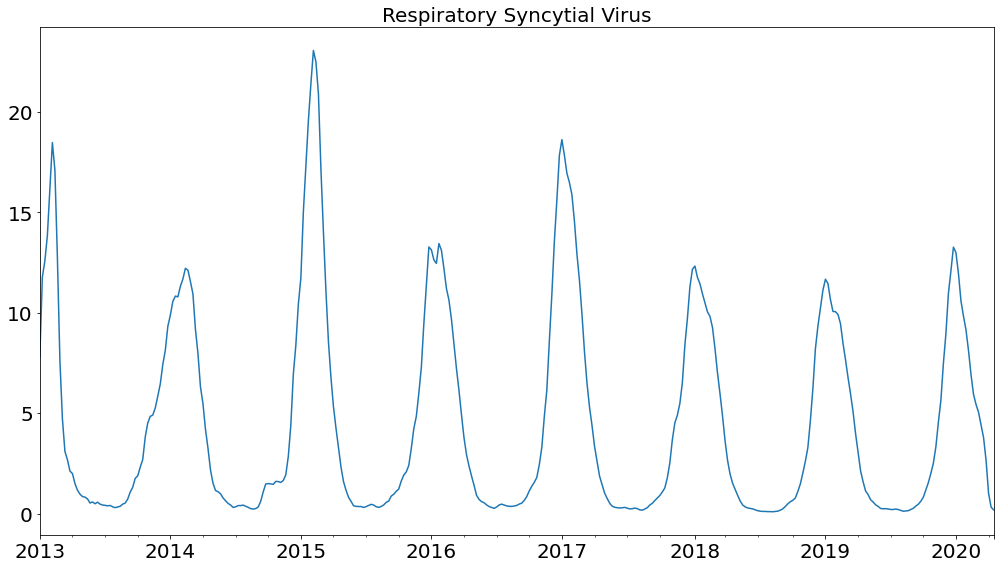

In [ ]:
for x in combined.loc[:, 'on100':].columns:
    combined[x].resample('W').mean().plot(figsize=(14,8))
    if x == 'on100':
        plt.title('TURN (100 Scale)', fontdict={'fontsize': 20})
    else:
        plt.title(x, fontdict={'fontsize': 20})
    if x == 'Human Rhinovirus/Enterovirus':
        save_fig("TURN_Percent_Detections_HRV")
    else:
        save_fig("TURN_Percent_Detections_"+x)
    plt.show()

Saving figure TURN_Percent_Detection_Stacked


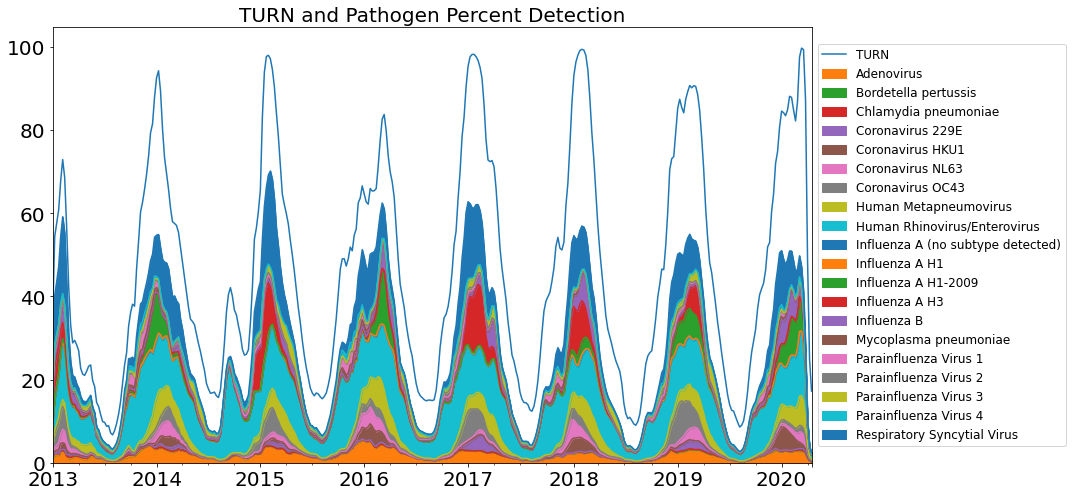

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

# plots
combined.on100.resample('W').mean().plot(label='TURN')
combined.iloc[:, 3:].resample('W').mean().plot.area(ax=ax)

# Remove legend title
plt.legend(title=False, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('TURN and Pathogen Percent Detection', fontdict={'fontsize': 20})

save_fig("TURN_Percent_Detection_Stacked")

plt.show()

---
# ILI Percent Detection (From CDC)

In [ ]:
iliData = pd.read_csv('/content/drive/Shared drives/BioFire/Data/ILI/ILINet.csv', header=1)

# Format date and use as index
iliData.index = pd.to_datetime(((iliData.YEAR.astype(str) + iliData.WEEK.astype(str)) + '0'), format='%Y%W%w').rename('Date')

# Sum % WEIGHTED ILI by date
iliData = iliData["% WEIGHTED ILI"].sum(level='Date').to_frame()

Saving figure TURN_Correlation_ILI


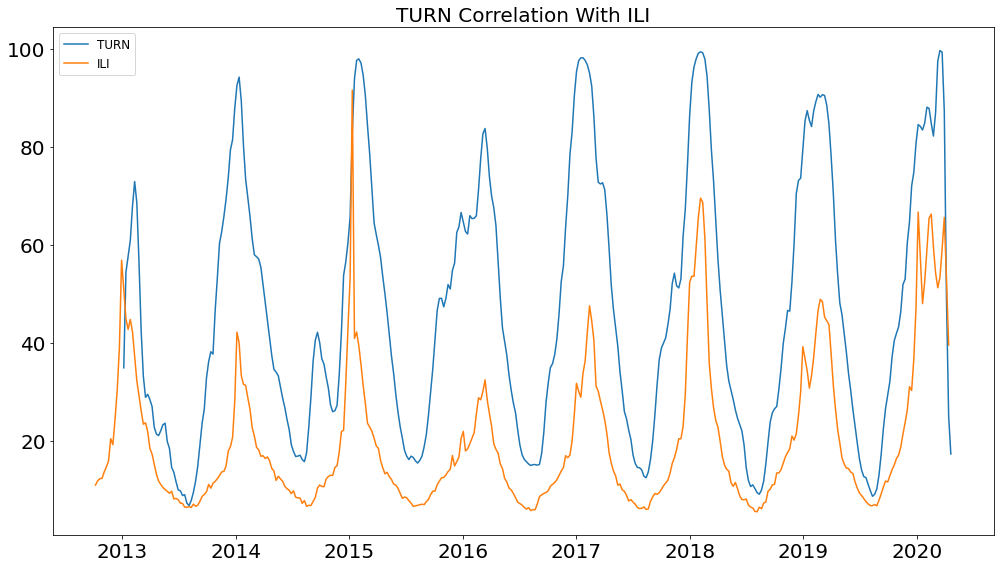

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(turn.on100.resample('W').mean(), label='TURN')
plt.plot(iliData, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI', fontdict={'fontsize': 20})
save_fig("TURN_Correlation_ILI")
plt.show()

In [ ]:
# Correlation between ILI and TURN
merged = iliData.merge(turn.on100.resample('W').mean().to_frame(), how='inner', left_index=True, right_index=True)
merged.corr()

% WEIGHTED ILI     on100
% WEIGHTED ILI        1.000000  0.828115
on100                 0.828115  1.000000

---
# NREVSS Data

### CDC Data (Percent Detection)

In [ ]:
def readCdcData(filename):
    df = pd.read_csv('/content/drive/Shared drives/BioFire/Data/NREVSS Data/'+filename+'.csv')
    df.index = pd.to_datetime((df.RepWeekDate.astype(str)), format='%m/%d/%Y').rename('Date')
    return df.PCR_Detection.to_frame(name=filename)

In [ ]:
adenovirusCDC = readCdcData('Adenovirus')
metapneumovirusCDC = readCdcData('Metapneumovirus')
parainfluenzaType1CDC = readCdcData('ParainfluenzaType1')
parainfluenzaType2CDC = readCdcData('ParainfluenzaType2')
parainfluenzaType3CDC = readCdcData('ParainfluenzaType3')
rsvCDC = readCdcData('RSV')

# Coronavirus
coronavirusCDC = pd.read_csv('/content/drive/Shared drives/BioFire/Data/NREVSS Data/CoronaVirus.csv')
coronavirusCDC.index = pd.to_datetime((coronavirusCDC.RepWeekDate.astype(str)), format='%m/%d/%Y').rename('Date')
coronavirusCDC = coronavirusCDC.drop(columns = 'RepWeekDate')

# Influenza A
influenzaACDC = pd.read_csv('/content/drive/Shared drives/BioFire/Data/NREVSS Data/Influenza.csv')
influenzaACDC.index = pd.to_datetime((influenzaACDC.YEAR.astype(str) + influenzaACDC.WEEK.astype(str) + '0'), format='%Y%W%w').rename('Date') # Date to index
influenzaACDC = influenzaACDC[influenzaACDC.columns[influenzaACDC.columns.str.startswith(('A','TOTAL SPECIMENS'))]] # Total Specimens and Influenza A columns
influenzaACDC = influenzaACDC.groupby(level=0).sum() # Sum by date
missingDates = pd.date_range(min(influenzaACDC.index), max(influenzaACDC.index)) # Fill in missing dates
influenzaACDC = influenzaACDC.reindex(missingDates, fill_value = 0) # Reindex using missingDates and fill with 0s
influenzaACDC = influenzaACDC.rolling(window = 21, center=True).mean() # 21 day rolling average
influenzaACDC = influenzaACDC.iloc[:,1:].divide(influenzaACDC['TOTAL SPECIMENS'], axis=0) * 100 # Percent detection
influenzaACDC = influenzaACDC.rename(columns={"A (2009 H1N1)": "Influenza A H1-2009",
                                              "A (H1)": "Influenza A H1",
                                              "A (H3)": "Influenza A H3",
                                              "A (Unable to Subtype)": "Influenza A (no subtype detected)",
                                              "A (Subtyping not Performed)": "Influenza A (Subtyping not Performed)"})

# Merge all data
cdcData = pd.concat([adenovirusCDC, coronavirusCDC, metapneumovirusCDC, parainfluenzaType1CDC, parainfluenzaType2CDC, parainfluenzaType3CDC, rsvCDC, influenzaACDC], axis=1)

### BioFire

In [ ]:
bioFireData = positivePercentDetection[['Adenovirus',
                                'Coronavirus HKU1',
                                'Coronavirus NL63',
                                'Coronavirus OC43',
                                'Coronavirus 229E',
                                'Human Metapneumovirus',
                                'Parainfluenza Virus 1',
                                'Parainfluenza Virus 2',
                                'Parainfluenza Virus 3',
                                'Respiratory Syncytial Virus',
                                'Influenza A H1-2009',
                                'Influenza A H1',
                                'Influenza A H3',
                                'Influenza A (no subtype detected)']]

# Rename columns
bioFireData = bioFireData.rename(columns={"Coronavirus HKU1": "CoVHKU1",
                                          "Coronavirus NL63": "CoVNL63",
                                          "Coronavirus OC43": "CoVOC43",
                                          "Coronavirus 229E": "CoV229E",
                                          "Human Metapneumovirus": "Metapneumovirus",
                                          "Parainfluenza Virus 1": "ParainfluenzaType1",
                                          "Parainfluenza Virus 2": "ParainfluenzaType2",
                                          "Parainfluenza Virus 3": "ParainfluenzaType3",
                                          "Respiratory Syncytial Virus": "RSV"})

### Stacked Area Chart CDC and BioFire

Saving figure BioFire_CDC_Percent_Detection_Stacked


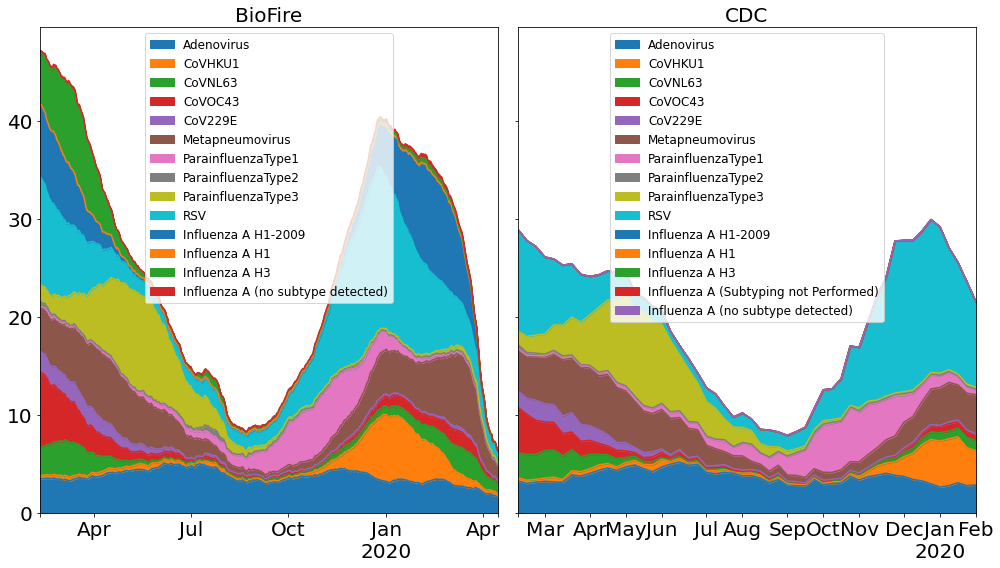

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,8), sharey=True)

axes[0].set_title('BioFire', size=20)
bioFireData.loc['2019-02-09':].plot.area(ax = axes[0])
axes[0].legend().set_title('') # remove legend title

axes[1].set_title('CDC', size=20)
cdcData.loc['2019-02-09':].plot.area(ax = axes[1])

# tick label size
for columns in axes:
  columns.minorticks_off() # remove minor ticks
  columns.xaxis.label.set_visible(False) # remove xaxis label

save_fig("BioFire_CDC_Percent_Detection_Stacked")

plt.show()

### Comparison Graphs

Saving figure BioFire_CDC_Percent_Detection_Separated


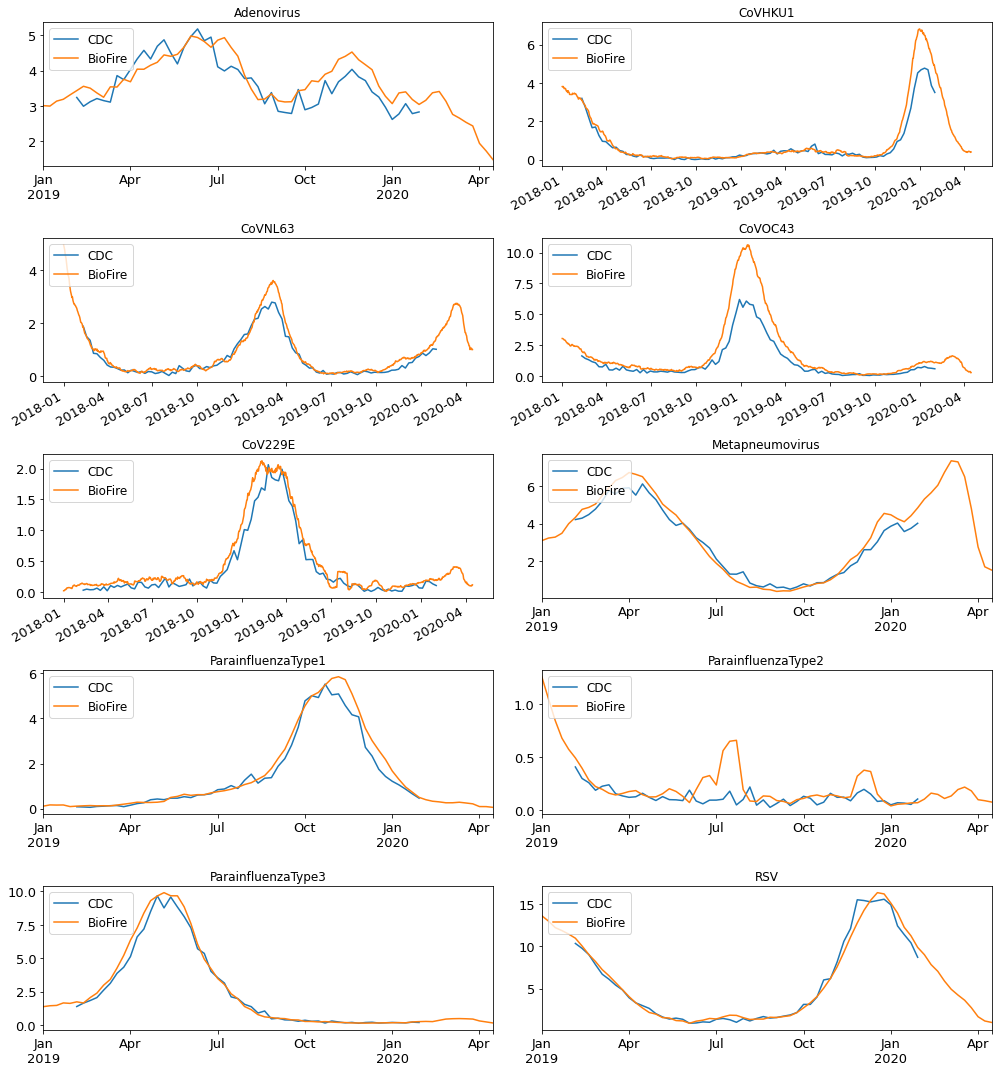

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,15))
fig.subplots_adjust(hspace=0.5) # add space between graphs

# Adenovirus
axes[0,0].title.set_text('Adenovirus')
cdcData.Adenovirus.loc['2019-01-01':].plot(label="CDC", ax = axes[0,0])
bioFireData.Adenovirus.loc['2019-01-01':].plot(label="BioFire", ax = axes[0,0])

# CoVHKU1
axes[0,1].title.set_text('CoVHKU1')
cdcData.CoVHKU1.plot(label="CDC", ax = axes[0,1])
bioFireData.CoVHKU1.loc['2018-01-01':].plot(label="BioFire", ax = axes[0,1])

# CoVNL63
axes[1,0].title.set_text('CoVNL63')
cdcData.CoVNL63.plot(label="CDC", ax = axes[1,0])
bioFireData.CoVNL63.loc['2018-01-01':].plot(label="BioFire", ax = axes[1,0])

# CoVOC43
axes[1,1].title.set_text('CoVOC43')
cdcData.CoVOC43.plot(label="CDC", ax = axes[1,1])
bioFireData.CoVOC43.loc['2018-01-01':].plot(label="BioFire", ax = axes[1,1])

# CoV229E
axes[2,0].title.set_text('CoV229E')
cdcData.CoV229E.plot(label="CDC", ax = axes[2,0])
bioFireData.CoV229E.loc['2018-01-01':].plot(label="BioFire", ax = axes[2,0])

# Metapneumovirus
axes[2,1].title.set_text('Metapneumovirus')
cdcData.Metapneumovirus.loc['2019-01-01':].plot(label="CDC", ax = axes[2,1])
bioFireData.Metapneumovirus.loc['2019-01-01':].plot(label="BioFire", ax = axes[2,1])

# ParainfluenzaType1
axes[3,0].title.set_text('ParainfluenzaType1')
cdcData.ParainfluenzaType1.loc['2019-01-01':].plot(label="CDC", ax = axes[3,0])
bioFireData.ParainfluenzaType1.loc['2019-01-01':].plot(label="BioFire", ax = axes[3,0])

# ParainfluenzaType2
axes[3,1].title.set_text('ParainfluenzaType2')
cdcData.ParainfluenzaType2.loc['2019-01-01':].plot(label="CDC", ax = axes[3,1])
bioFireData.ParainfluenzaType2.loc['2019-01-01':].plot(label="BioFire", ax = axes[3,1])

# ParainfluenzaType3
axes[4,0].title.set_text('ParainfluenzaType3')
cdcData.ParainfluenzaType3.loc['2019-01-01':].plot(label="CDC", ax = axes[4,0])
bioFireData.ParainfluenzaType3.loc['2019-01-01':].plot(label="BioFire", ax = axes[4,0])

# RSV
axes[4,1].title.set_text('RSV')
cdcData.RSV.loc['2019-01-01':].plot(label="CDC", ax = axes[4,1])
bioFireData.RSV.loc['2019-01-01':].plot(label="BioFire", ax = axes[4,1])

# tick label size
for col in axes:
    for ax_row in col:
        ax_row.tick_params(labelsize=13)
        ax_row.minorticks_off() # remove minor ticks
        ax_row.xaxis.label.set_visible(False) # remove xaxis label
        ax_row.legend(loc=2)

save_fig("BioFire_CDC_Percent_Detection_Separated")
plt.show()

---
# Correlations


In [ ]:
# Without Coronavirus
print(cdcData[['Adenovirus',
         'Metapneumovirus',
         'ParainfluenzaType1',
         'ParainfluenzaType2',
         'ParainfluenzaType3',
         'RSV']].corrwith(bioFireData[['Adenovirus',
                                       'Metapneumovirus',
                                       'ParainfluenzaType1',
                                       'ParainfluenzaType2',
                                       'ParainfluenzaType3',
                                       'RSV']].loc['2019-02-09':], method = 'pearson').reset_index().to_string(header=None, index=None))

         Adenovirus  0.850321
    Metapneumovirus  0.989309
 ParainfluenzaType1  0.987797
 ParainfluenzaType2  0.375649
 ParainfluenzaType3  0.995935
                RSV  0.990917


In [ ]:
# Coronavirus
print(cdcData[['CoVHKU1',
         'CoVNL63',
         'CoVOC43',
         'CoV229E']].corrwith(bioFireData[['CoVHKU1',
                                           'CoVNL63',
                                           'CoVOC43',
                                           'CoV229E']].loc['2018-02-09':], method = 'pearson').reset_index().to_string(header=None, index=None))

 CoVHKU1  0.987055
 CoVNL63  0.978596
 CoVOC43  0.993443
 CoV229E  0.983899


### BioFire Normalized

In [ ]:
bioFireData_Normalized = positivePercentDetection_mul_turn[['Adenovirus',
                                'Coronavirus HKU1',
                                'Coronavirus NL63',
                                'Coronavirus OC43',
                                'Coronavirus 229E',
                                'Human Metapneumovirus',
                                'Parainfluenza Virus 1',
                                'Parainfluenza Virus 2',
                                'Parainfluenza Virus 3',
                                'Respiratory Syncytial Virus',
                                'Influenza A H1-2009',
                                'Influenza A H1',
                                'Influenza A H3',
                                'Influenza A (no subtype detected)']]

# Rename columns
bioFireData_Normalized = bioFireData_Normalized.rename(columns={"Coronavirus HKU1": "CoVHKU1",
                                          "Coronavirus NL63": "CoVNL63",
                                          "Coronavirus OC43": "CoVOC43",
                                          "Coronavirus 229E": "CoV229E",
                                          "Human Metapneumovirus": "Metapneumovirus",
                                          "Parainfluenza Virus 1": "ParainfluenzaType1",
                                          "Parainfluenza Virus 2": "ParainfluenzaType2",
                                          "Parainfluenza Virus 3": "ParainfluenzaType3",
                                          "Respiratory Syncytial Virus": "RSV"})

Saving figure BioFire_Normalized_CDC_Comparison


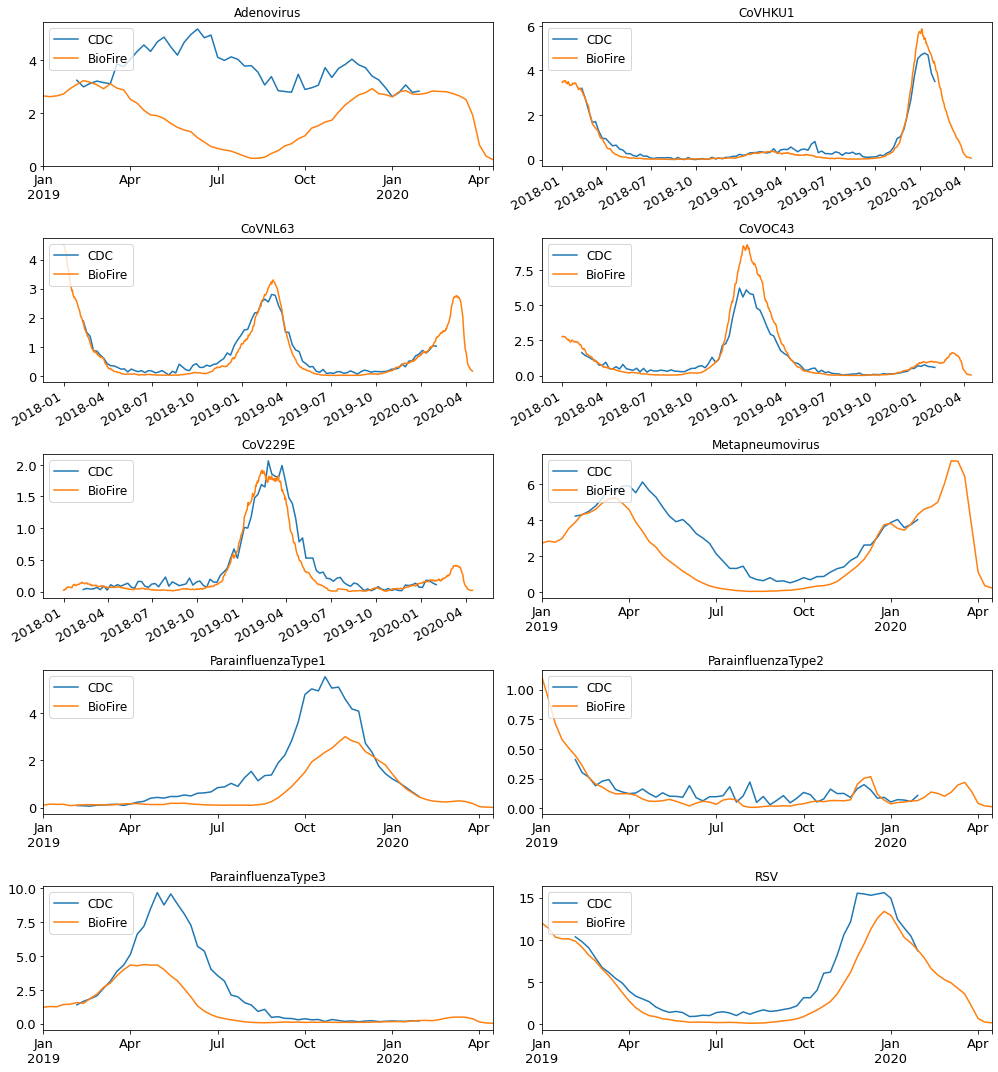

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14,15))
fig.subplots_adjust(hspace=0.5) # add space between graphs

# Adenovirus
axes[0,0].title.set_text('Adenovirus')
cdcData.Adenovirus.loc['2019-01-01':].plot(label="CDC", ax = axes[0,0])
bioFireData_Normalized.Adenovirus.loc['2019-01-01':].plot(label="BioFire", ax = axes[0,0])

# CoVHKU1
axes[0,1].title.set_text('CoVHKU1')
cdcData.CoVHKU1.plot(label="CDC", ax = axes[0,1])
bioFireData_Normalized.CoVHKU1.loc['2018-01-01':].plot(label="BioFire", ax = axes[0,1])

# CoVNL63
axes[1,0].title.set_text('CoVNL63')
cdcData.CoVNL63.plot(label="CDC", ax = axes[1,0])
bioFireData_Normalized.CoVNL63.loc['2018-01-01':].plot(label="BioFire", ax = axes[1,0])

# CoVOC43
axes[1,1].title.set_text('CoVOC43')
cdcData.CoVOC43.plot(label="CDC", ax = axes[1,1])
bioFireData_Normalized.CoVOC43.loc['2018-01-01':].plot(label="BioFire", ax = axes[1,1])

# CoV229E
axes[2,0].title.set_text('CoV229E')
cdcData.CoV229E.plot(label="CDC", ax = axes[2,0])
bioFireData_Normalized.CoV229E.loc['2018-01-01':].plot(label="BioFire", ax = axes[2,0])

# Metapneumovirus
axes[2,1].title.set_text('Metapneumovirus')
cdcData.Metapneumovirus.loc['2019-01-01':].plot(label="CDC", ax = axes[2,1])
bioFireData_Normalized.Metapneumovirus.loc['2019-01-01':].plot(label="BioFire", ax = axes[2,1])

# ParainfluenzaType1
axes[3,0].title.set_text('ParainfluenzaType1')
cdcData.ParainfluenzaType1.loc['2019-01-01':].plot(label="CDC", ax = axes[3,0])
bioFireData_Normalized.ParainfluenzaType1.loc['2019-01-01':].plot(label="BioFire", ax = axes[3,0])

# ParainfluenzaType2
axes[3,1].title.set_text('ParainfluenzaType2')
cdcData.ParainfluenzaType2.loc['2019-01-01':].plot(label="CDC", ax = axes[3,1])
bioFireData_Normalized.ParainfluenzaType2.loc['2019-01-01':].plot(label="BioFire", ax = axes[3,1])

# ParainfluenzaType3
axes[4,0].title.set_text('ParainfluenzaType3')
cdcData.ParainfluenzaType3.loc['2019-01-01':].plot(label="CDC", ax = axes[4,0])
bioFireData_Normalized.ParainfluenzaType3.loc['2019-01-01':].plot(label="BioFire", ax = axes[4,0])

# RSV
axes[4,1].title.set_text('RSV')
cdcData.RSV.loc['2019-01-01':].plot(label="CDC", ax = axes[4,1])
bioFireData_Normalized.RSV.loc['2019-01-01':].plot(label="BioFire", ax = axes[4,1])

# tick label size
for col in axes:
    for ax_row in col:
        ax_row.tick_params(labelsize=13)
        ax_row.minorticks_off() # remove minor ticks
        ax_row.xaxis.label.set_visible(False) # remove xaxis label
        ax_row.legend(loc=2)

save_fig("BioFire_Normalized_CDC_Comparison")
plt.show()

In [ ]:
# Without Coronavirus
print(cdcData[['Adenovirus',
         'Metapneumovirus',
         'ParainfluenzaType1',
         'ParainfluenzaType2',
         'ParainfluenzaType3',
         'RSV']].corrwith(bioFireData_Normalized[['Adenovirus',
                                       'Metapneumovirus',
                                       'ParainfluenzaType1',
                                       'ParainfluenzaType2',
                                       'ParainfluenzaType3',
                                       'RSV']].loc['2019-02-09':], method = 'pearson').reset_index().to_string(header=None, index=None))

         Adenovirus -0.274902
    Metapneumovirus  0.861055
 ParainfluenzaType1  0.861660
 ParainfluenzaType2  0.795826
 ParainfluenzaType3  0.838624
                RSV  0.946843


In [ ]:
# Coronavirus
print(cdcData[['CoVHKU1',
         'CoVNL63',
         'CoVOC43',
         'CoV229E']].corrwith(bioFireData[['CoVHKU1',
                                           'CoVNL63',
                                           'CoVOC43',
                                           'CoV229E']].loc['2018-02-09':], method = 'pearson').reset_index().to_string(header=None, index=None))

 CoVHKU1  0.987055
 CoVNL63  0.978596
 CoVOC43  0.993443
 CoV229E  0.983899


---
# Region Data

### CDC Data

In [ ]:
def readCdcData2(filename, name):
    df = pd.read_csv('/content/drive/Shared drives/BioFire/Data/Region_wise/'+filename, index_col=0)
    df.index = pd.to_datetime(df.RepWeekDate).rename('Date')
    return df.PCR_Detection.to_frame(name=name)

In [ ]:
def readCorona(filename, region):
    df = pd.read_csv('/content/drive/Shared drives/BioFire/Data/Region_wise/Coronavirus/'+filename, index_col=0)
    df.index = pd.to_datetime(df.RepWeekDate).rename('Date')
    return df.rename(columns = {"CoVHKU1": "CoVHKU1_"+region,
                                "CoVNL63":"CoVNL63_"+region,
                                "CoVOC43": "CoVOC43_"+region,
                                "CoV229E": "CoV229E_"+region})

In [ ]:
#################
### Northeast ###
#################

rsvNE = readCdcData2('RSV/RSV_positives_NE.csv', 'RSV_NE')
HMPVNE = readCdcData2('HMPV/HMPV_NE_positive.csv', 'Metapneumovirus_NE')
coronavirusNE = readCorona('Corona_NE_positive.csv', 'NE')

#############
### South ###
#############

rsvSouth = readCdcData2('RSV/RSV_percentpositive-South.csv', 'RSV_South')
HMPVSouth = readCdcData2('HMPV/HMPV_South_positive.csv', 'Metapneumovirus_South')
coronavirusSouth = readCorona('Corona_South_positives.csv', 'South')

###############
### Midwest ###
###############

rsvMW = readCdcData2('RSV/RSV_positives_Midwest.csv', 'RSV_MW')
HMPVMW = readCdcData2('HMPV/HMPV_MW_positive.csv', 'Metapneumovirus_MW')
coronavirusMW = readCorona('Corona_Midwest_postive.csv', 'MW')

############
### West ###
############

rsvW = readCdcData2('RSV/RSV_positives_West.csv', 'RSV_W')
HMPVW = readCdcData2('HMPV/HMPV_West_positive.csv', 'Metapneumovirus_W')
coronavirusW = readCorona('Corona_West_positive.csv', 'W')

### BioFire Data

In [ ]:
def bioFireRegion(regions):
    df = rp_data.copy()
    df = df[df.Region.isin(regions)]
    df.Date = pd.to_datetime(df.Date)
    df = df.drop(columns=['Region','ZipCode'])

    # Positives
    positives = df[df.ResultType == 'organism'].drop(columns = ['ResultType']).drop_duplicates() # Filter for ResultType = organism
    positives = pd.crosstab(index = positives.Date, columns = positives.TargetName) # Count number of positive tests per day grouped by TargetName
    positives = positives.rolling(window = 21, center=True).mean() # 21 day rolling average

    # Total Utilization Rate
    df['totalUtilizationRate'] = df.Date.map(df.groupby('Date').ID.nunique()) # Count tests per day
    df = df.set_index(df.Date) # Reindex using Date
    df = df.drop(columns = ['ID','ResultType','TargetName']).drop_duplicates() # Drop unneeded columns and duplicates
    missingDates = pd.date_range(min(df.Date), max(df.Date)) # Get missing dates
    df = df.reindex(missingDates, fill_value = 0).drop(columns = 'Date') # Reindex using missingDates and fill with 0s
    df = df.rolling(window = 21, center=True).mean() # 21 day rolling average

    # Percent Detection
    percentDetection = positives.divide(pd.Series(df.totalUtilizationRate), axis=0) * 100

    return df, positives, percentDetection;

In [ ]:
NE_Regions = ['PA','NY','CT','ME','MA','NH','RI','VT','NJ']
S_Regions = ['TX','OK','AR','LA','MS','AL','TN','KY','WV','MD','DE','DC','VA','NC','SC','GA','FL']
MW_Regions = ['ND','SD','NE','KS','MN','IA','MO','WI','IL','MI','IN','OH']
W_Regions = ['WA','OR','CA','NV','AZ','UT','CO','NM','WY','MT','ID','AK','HI']

# Northeast
northEastRegion, northEastRegionPositives, northEastRegionPercentDetection = bioFireRegion(NE_Regions)

# South
SouthRegion, SouthRegionPositives, SouthRegionPercentDetection = bioFireRegion(S_Regions)

# Midwest
MidWestRegion, MidWestRegionPositives, MidWestRegionPercentDetection = bioFireRegion(MW_Regions)

# West
WestRegion, WestRegionPositives, WestRegionPercentDetection = bioFireRegion(W_Regions)

### Comparison Graphs

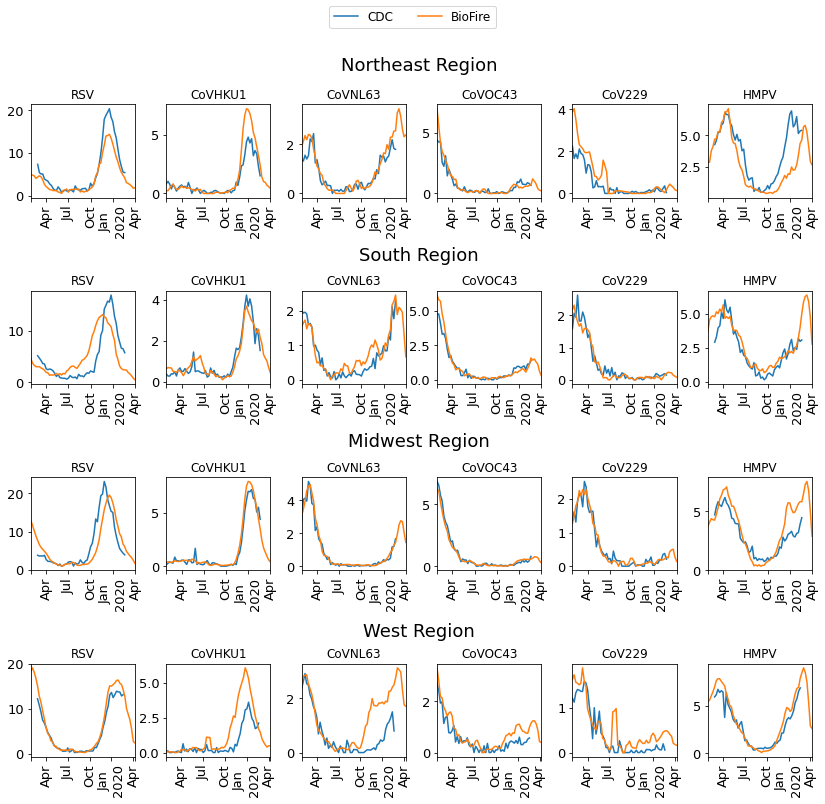

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(14,12))
fig.subplots_adjust(hspace=1, wspace = 0.3)

#################
### Northeast ###
#################

# RSV
axes[0,0].title.set_text('RSV')
rsvNE.RSV_NE.loc['2019-01-01':].plot(label="CDC", ax = axes[0,0])
northEastRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[0,0])

# CoVHKU1
axes[0,1].title.set_text('CoVHKU1')
coronavirusNE.CoVHKU1_NE.loc['2019-02-01':].plot(label="CDC", ax = axes[0,1])
northEastRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':].plot(label="BioFire", ax = axes[0,1])

# CoVNL63
axes[0,2].title.set_text('CoVNL63')
coronavirusNE.CoVNL63_NE.loc['2019-02-01':].plot(label="CDC", ax = axes[0,2])
northEastRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':].plot(label="BioFire", ax = axes[0,2])

# CoVOC43
axes[0,3].title.set_text('CoVOC43')
coronavirusNE.CoVOC43_NE.loc['2019-02-01':].plot(label="CDC", ax = axes[0,3])
northEastRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':].plot(label="BioFire", ax = axes[0,3])

# CoV229
axes[0,4].title.set_text('CoV229')
coronavirusNE.CoV229E_NE.loc['2019-02-01':].plot(label="CDC", ax = axes[0,4])
northEastRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':].plot(label="BioFire", ax = axes[0,4])

# HMPV
axes[0,5].title.set_text('HMPV')
HMPVNE.Metapneumovirus_NE.loc['2019-02-01':].plot(label="CDC", ax = axes[0,5])
northEastRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[0,5])

#############
### South ###
#############

# RSV
axes[1,0].title.set_text('RSV')
rsvSouth.RSV_South.loc['2019-01-01':].plot(label="CDC", ax = axes[1,0])
SouthRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[1,0])

# CoVHKU1
axes[1,1].title.set_text('CoVHKU1')
coronavirusSouth.CoVHKU1_South.loc['2019-02-01':].plot(label="CDC", ax = axes[1,1])
SouthRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':].plot(label="BioFire", ax = axes[1,1])

# CoVNL63
axes[1,2].title.set_text('CoVNL63')
coronavirusSouth.CoVNL63_South.loc['2019-02-01':].plot(label="CDC", ax = axes[1,2])
SouthRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':].plot(label="BioFire", ax = axes[1,2])

# CoVOC43
axes[1,3].title.set_text('CoVOC43')
coronavirusSouth.CoVOC43_South.loc['2019-02-01':].plot(label="CDC", ax = axes[1,3])
SouthRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':].plot(label="BioFire", ax = axes[1,3])

# CoV229
axes[1,4].title.set_text('CoV229')
coronavirusSouth.CoV229E_South.loc['2019-02-01':].plot(label="CDC", ax = axes[1,4])
SouthRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':].plot(label="BioFire", ax = axes[1,4])

# HMPV
axes[1,5].title.set_text('HMPV')
HMPVSouth.Metapneumovirus_South.loc['2019-02-01':].plot(label="CDC", ax = axes[1,5])
SouthRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[1,5])

###############
### Midwest ###
###############

# RSV
axes[2,0].title.set_text('RSV')
rsvMW.RSV_MW.loc['2019-01-01':].plot(label="CDC", ax = axes[2,0])
MidWestRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[2,0])

# CoVHKU1
axes[2,1].title.set_text('CoVHKU1')
coronavirusMW.CoVHKU1_MW.loc['2019-02-01':].plot(label="CDC", ax = axes[2,1])
MidWestRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':].plot(label="BioFire", ax = axes[2,1])

# CoVNL63
axes[2,2].title.set_text('CoVNL63')
coronavirusMW.CoVNL63_MW.loc['2019-02-01':].plot(label="CDC", ax = axes[2,2])
MidWestRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':].plot(label="BioFire", ax = axes[2,2])

# CoVOC43
axes[2,3].title.set_text('CoVOC43')
coronavirusMW.CoVOC43_MW.loc['2019-02-01':].plot(label="CDC", ax = axes[2,3])
MidWestRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':].plot(label="BioFire", ax = axes[2,3])

# CoV229
axes[2,4].title.set_text('CoV229')
coronavirusMW.CoV229E_MW.loc['2019-02-01':].plot(label="CDC", ax = axes[2,4])
MidWestRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':].plot(label="BioFire", ax = axes[2,4])

# HMPV
axes[2,5].title.set_text('HMPV')
HMPVMW.Metapneumovirus_MW.loc['2019-02-01':].plot(label="CDC", ax = axes[2,5])
MidWestRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[2,5])

############
### West ###
############

# RSV
axes[3,0].title.set_text('RSV')
rsvW.RSV_W.loc['2019-01-01':].plot(label="CDC", ax = axes[3,0])
WestRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[3,0])

# CoVHKU1
axes[3,1].title.set_text('CoVHKU1')
coronavirusW.CoVHKU1_W.loc['2019-02-01':].plot(label="CDC", ax = axes[3,1])
WestRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':].plot(label="BioFire", ax = axes[3,1])

# CoVNL63
axes[3,2].title.set_text('CoVNL63')
coronavirusW.CoVNL63_W.loc['2019-02-01':].plot(label="CDC", ax = axes[3,2])
WestRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':].plot(label="BioFire", ax = axes[3,2])

# CoVOC43
axes[3,3].title.set_text('CoVOC43')
coronavirusW.CoVOC43_W.loc['2019-02-01':].plot(label="CDC", ax = axes[3,3])
WestRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':].plot(label="BioFire", ax = axes[3,3])

# CoV229
axes[3,4].title.set_text('CoV229')
coronavirusW.CoV229E_W.loc['2019-02-01':].plot(label="CDC", ax = axes[3,4])
WestRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':].plot(label="BioFire", ax = axes[3,4])

# HMPV
axes[3,5].title.set_text('HMPV')
HMPVW.Metapneumovirus_W.loc['2019-02-01':].plot(label="CDC", ax = axes[3,5])
WestRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':].plot(label="BioFire", ax = axes[3,5])

# tick label size
for col in axes:
  for ax_row in col:
    ax_row.tick_params(labelsize=13)
    ax_row.tick_params(axis='x', labelrotation=90)
    ax_row.minorticks_off() # remove minor ticks
    ax_row.xaxis.label.set_visible(False) # remove xaxis label

plt.figtext(0.51,0.935, "Northeast Region", ha="center", va="top", fontsize=18)
plt.figtext(0.51,0.715, "South Region", ha="center", va="top", fontsize=18)
plt.figtext(0.51,0.5, "Midwest Region", ha="center", va="top", fontsize=18)
plt.figtext(0.51,0.28, "West Region", ha="center", va="top", fontsize=18)

lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'upper center', ncol=2)

#save_fig("BioFire_CDC_Four_Regions")

plt.show()

### Correlations

In [ ]:
#################
### Northeast ###
#################

# RSV
print(rsvNE.loc['2019-02-01':].corrwith(northEastRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVHKU1
print(coronavirusNE.CoVHKU1_NE.loc['2019-02-01':].to_frame().corrwith(northEastRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVNL63
print(coronavirusNE.CoVNL63_NE.loc['2019-02-01':].to_frame().corrwith(northEastRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVOC43
print(coronavirusNE.CoVOC43_NE.loc['2019-02-01':].to_frame().corrwith(northEastRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoV229
print(coronavirusNE.CoV229E_NE.loc['2019-02-01':].to_frame().corrwith(northEastRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# HMPV
print(HMPVNE.loc['2019-02-01':].corrwith(northEastRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

 RSV_NE  0.989332
 CoVHKU1_NE  0.970172
 CoVNL63_NE  0.936902
 CoVOC43_NE  0.956956
 CoV229E_NE  0.908575
 Metapneumovirus_NE  0.80824


In [ ]:
#############
### South ###
#############

# RSV
print(rsvSouth.loc['2019-02-01':].corrwith(SouthRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVHKU1
print(coronavirusSouth.CoVHKU1_South.loc['2019-02-01':].to_frame().corrwith(SouthRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVNL63
print(coronavirusSouth.CoVNL63_South.loc['2019-02-01':].to_frame().corrwith(SouthRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVOC43
print(coronavirusSouth.CoVOC43_South.loc['2019-02-01':].to_frame().corrwith(SouthRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoV229
print(coronavirusSouth.CoV229E_South.loc['2019-02-01':].to_frame().corrwith(SouthRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# HMPV
print(HMPVSouth.loc['2019-02-01':].corrwith(SouthRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

 RSV_South  0.682825
 CoVHKU1_South  0.953554
 CoVNL63_South  0.914016
 CoVOC43_South  0.981278
 CoV229E_South  0.954439
 Metapneumovirus_South  0.912073


In [ ]:
###############
### Midwest ###
###############

# RSV
print(rsvMW.loc['2019-02-01':].corrwith(MidWestRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVHKU1
print(coronavirusMW.CoVHKU1_MW.loc['2019-02-01':].to_frame().corrwith(MidWestRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVNL63
print(coronavirusMW.CoVNL63_MW.loc['2019-02-01':].to_frame().corrwith(MidWestRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVOC43
print(coronavirusMW.CoVOC43_MW.loc['2019-02-01':].to_frame().corrwith(MidWestRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoV229
print(coronavirusMW.CoV229E_MW.loc['2019-02-01':].to_frame().corrwith(MidWestRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# HMPV
print(HMPVMW.loc['2019-02-01':].corrwith(MidWestRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

 RSV_MW  0.841802
 CoVHKU1_MW  0.985735
 CoVNL63_MW  0.988591
 CoVOC43_MW  0.996239
 CoV229E_MW  0.976314
 Metapneumovirus_MW  0.909071


In [ ]:
############
### West ###
############

# RSV
print(rsvW.loc['2019-02-01':].corrwith(WestRegionPercentDetection['Respiratory Syncytial Virus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVHKU1
print(coronavirusW.CoVHKU1_W.loc['2019-02-01':].to_frame().corrwith(WestRegionPercentDetection['Coronavirus HKU1'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVNL63
print(coronavirusW.CoVNL63_W.loc['2019-02-01':].to_frame().corrwith(WestRegionPercentDetection['Coronavirus NL63'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoVOC43
print(coronavirusW.CoVOC43_W.loc['2019-02-01':].to_frame().corrwith(WestRegionPercentDetection['Coronavirus OC43'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# CoV229
print(coronavirusW.CoV229E_W.loc['2019-02-01':].to_frame().corrwith(WestRegionPercentDetection['Coronavirus 229E'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

# HMPV
print(HMPVW.loc['2019-02-01':].corrwith(WestRegionPercentDetection['Human Metapneumovirus'].loc['2019-02-01':], method = 'pearson').reset_index().to_string(header=None, index=None))

 RSV_W  0.995753
 CoVHKU1_W  0.875889
 CoVNL63_W  0.744962
 CoVOC43_W  0.929167
 CoV229E_W  0.875935
 Metapneumovirus_W  0.972252


### Regional TURN

In [ ]:
turn_Northeast = ((northEastRegion - northEastRegion.rolling(window = 730, center=True, min_periods=1).mean()) / northEastRegion.rolling(window = 730, center=True, min_periods=1).std()).dropna()
turn_South = ((SouthRegion - SouthRegion.rolling(window = 730, center=True, min_periods=1).mean()) / SouthRegion.rolling(window = 730, center=True, min_periods=1).std()).dropna()
turn_Midwest = ((MidWestRegion - MidWestRegion.rolling(window = 730, center=True, min_periods=1).mean()) / MidWestRegion.rolling(window = 730, center=True, min_periods=1).std()).dropna()
turn_West = ((WestRegion - WestRegion.rolling(window = 730, center=True, min_periods=1).mean()) / WestRegion.rolling(window = 730, center=True, min_periods=1).std()).dropna()

turn_Northeast['on100'] = st.norm.cdf(turn_Northeast) * 100
turn_South['on100'] = st.norm.cdf(turn_South) * 100
turn_Midwest['on100'] = st.norm.cdf(turn_Midwest) * 100
turn_West['on100'] = st.norm.cdf(turn_West) * 100

Saving figure BioFire_Regional_TURN


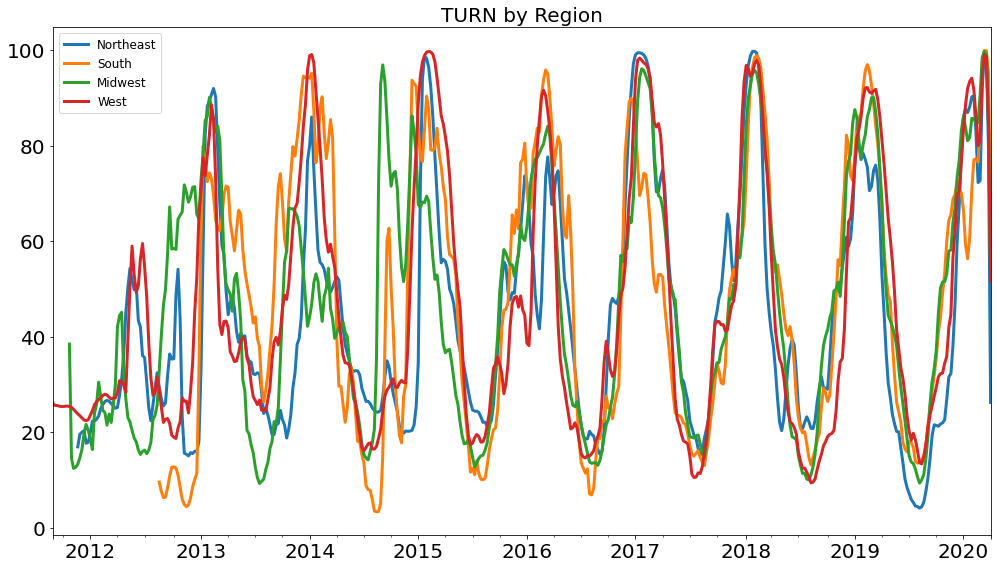

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.set_title('TURN by Region', fontdict={'fontsize': 20})

turn_Northeast.on100.resample('W').mean().plot(label='Northeast', linewidth=3)
turn_South.on100.resample('W').mean().plot(label='South', linewidth=3)
turn_Midwest.on100.resample('W').mean().plot(label='Midwest', linewidth=3)
turn_West.on100.resample('W').mean().plot(label='West', linewidth=3)

plt.legend()
save_fig("BioFire_Regional_TURN")
plt.show()

---
# HHS Regions

In [ ]:
def HHSRegion(regions):
    Region = rp_data[rp_data.Region.isin(regions[1])]
    Region = Region.drop(columns=['Region','ZipCode'])
    Region.Date = pd.to_datetime(Region.Date)
    Region['totalUtilizationRate'] = Region.Date.map(Region.groupby('Date').ID.nunique()) # Count tests per day
    Region = Region.set_index(Region.Date) # Reindex using Date
    Region = Region.drop(columns = ['ID','ResultType','TargetName']).drop_duplicates() # Drop unneeded columns and duplicates
    missingDates = pd.date_range(min(Region.Date), max(Region.Date)) # Get missing dates
    Region = Region.reindex(missingDates, fill_value = 0).drop(columns = 'Date') # Reindex using missingDates and fill with 0s
    Region = Region.rolling(window = 21, center=True).mean() # 21 day rolling average
    Region = ((Region - Region.rolling(window = 730, center=True, min_periods=1).mean()) / Region.rolling(window = 730, center=True, min_periods=1).std()).dropna()
    Region[regions[0]] = st.norm.cdf(Region) * 100
    return Region[regions[0]].to_frame()

In [ ]:
###################
### HHS Regions ###
###################

# 1 = Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, and Vermont
# 2 = New Jersey, New York, Puerto Rico, and the Virgin Islands
# 3 = Delaware, District of Columbia, Maryland, Pennsylvania, Virginia, and West Virginia
# 4 = Alabama, Florida, Georgia, Kentucky, Mississippi, North Carolina, South Carolina, and Tennessee
# 5 = Illinois, Indiana, Michigan, Minnesota, Ohio, and Wisconsin
# 6 = Arkansas, Louisiana, New Mexico, Oklahoma, and Texas
# 7 = Iowa, Kansas, Missouri, and Nebraska
# 8 = Colorado, Montana, North Dakota, South Dakota, Utah, and Wyoming
# 9 = Arizona, California, Hawaii, Nevada, American Samoa, Commonwealth of the Northern Mariana Islands, Federated States of Micronesia, Guam, Marshall Islands, and Republic of Palau
# 10 = Alaska, Idaho, Oregon, and Washington

Regions = [[1,['CT','ME','MA','NH','RI','VT']],
           [2,['NJ','NY','PR','VI']],
           [3,['DE','DC','MD','PA','VA','WV']],
           [4,['AL','FL','GA','KY','MS','NC','SC','TN']],
           [5,['IL','IN','MI','MN','OH','WI']],
           [6,['AR','LA','NM','OK','TX']],
           [7,['IA','KS','MO','NE']],
           [8,['CO','MT','ND','SD','UT','WY']],
           [9,['AZ','CA','HI','NV','AS','MP','FM','GU','MH','PW']],
           [10,['AK','ID','OR','WA']]
           ]

Region1 = HHSRegion(Regions[0])
Region2 = HHSRegion(Regions[1])
Region3 = HHSRegion(Regions[2])
Region4 = HHSRegion(Regions[3])
Region5 = HHSRegion(Regions[4])
Region6 = HHSRegion(Regions[5])
Region7 = HHSRegion(Regions[6])
Region8 = HHSRegion(Regions[7])
Region9 = HHSRegion(Regions[8])
Region10 = HHSRegion(Regions[9])

# Merge dataframes
from functools import reduce
data_frames = [Region1,Region2,Region3,Region4,Region5,Region6,Region7,Region8,Region9,Region10]
regionTURN = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), data_frames)

Saving figure BioFire_TURN_HHS_Region


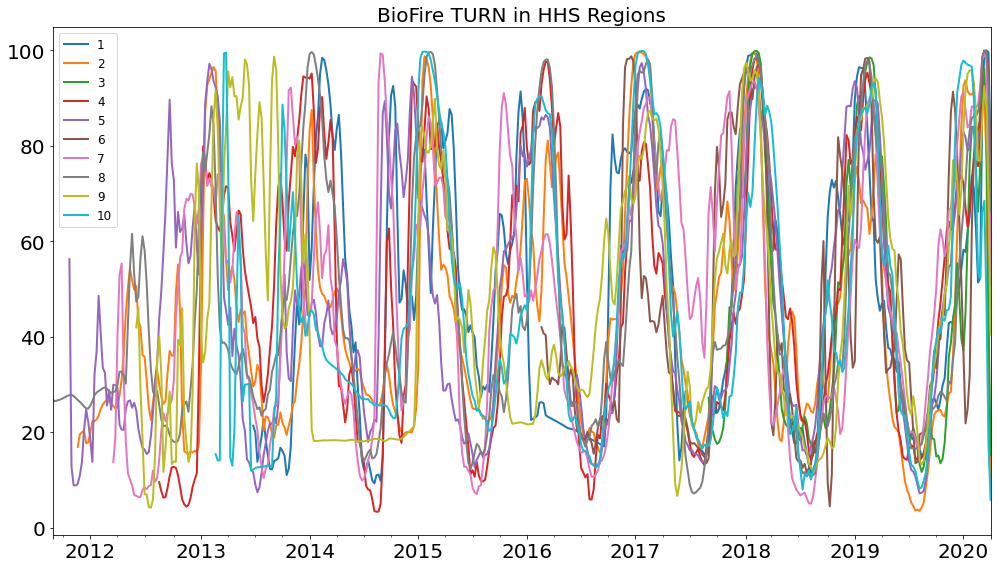

In [ ]:
regionTURN.resample('W').mean().plot(figsize=(14, 8), linewidth=2)
plt.title('BioFire TURN in HHS Regions', fontdict={'fontsize': 20})
save_fig("BioFire_TURN_HHS_Region")
plt.legend()
plt.show()

# ILI Regional Data

In [ ]:
iliDataRegion = pd.read_csv('/content/drive/Shared drives/BioFire/Data/ILI/ILINet.csv', header=1)

# Format date
iliDataRegion['Date'] = pd.to_datetime(((iliDataRegion.YEAR.astype(str) + iliDataRegion.WEEK.astype(str)) + '0'), format='%Y%W%w').rename('Date')
iliDataRegion = iliDataRegion[['Date', 'REGION', '% WEIGHTED ILI']]

# Sum % WEIGHTED ILI by date
iliDataRegion = iliDataRegion.groupby(['Date', 'REGION'], as_index=False).sum()
iliDataRegion.set_index('Date', inplace=True)

In [ ]:
# Create dataframe for each region
iliDataRegion1 = iliDataRegion[iliDataRegion.REGION == 'Region 1'].drop(columns="REGION")
iliDataRegion1['on100'] = st.norm.cdf(iliDataRegion1) * 100
iliDataRegion2 = iliDataRegion[iliDataRegion.REGION == 'Region 2'].drop(columns="REGION")
iliDataRegion2['on100'] = st.norm.cdf(iliDataRegion2) * 100
iliDataRegion3 = iliDataRegion[iliDataRegion.REGION == 'Region 3'].drop(columns="REGION")
iliDataRegion3['on100'] = st.norm.cdf(iliDataRegion3) * 100
iliDataRegion4 = iliDataRegion[iliDataRegion.REGION == 'Region 4'].drop(columns="REGION")
iliDataRegion4['on100'] = st.norm.cdf(iliDataRegion4) * 100
iliDataRegion5 = iliDataRegion[iliDataRegion.REGION == 'Region 5'].drop(columns="REGION")
iliDataRegion5['on100'] = st.norm.cdf(iliDataRegion5) * 100
iliDataRegion6 = iliDataRegion[iliDataRegion.REGION == 'Region 6'].drop(columns="REGION")
iliDataRegion6['on100'] = st.norm.cdf(iliDataRegion6) * 100
iliDataRegion7 = iliDataRegion[iliDataRegion.REGION == 'Region 7'].drop(columns="REGION")
iliDataRegion7['on100'] = st.norm.cdf(iliDataRegion7) * 100
iliDataRegion8 = iliDataRegion[iliDataRegion.REGION == 'Region 8'].drop(columns="REGION")
iliDataRegion8['on100'] = st.norm.cdf(iliDataRegion8) * 100
iliDataRegion9 = iliDataRegion[iliDataRegion.REGION == 'Region 9'].drop(columns="REGION")
iliDataRegion9['on100'] = st.norm.cdf(iliDataRegion9) * 100
iliDataRegion10 = iliDataRegion[iliDataRegion.REGION == 'Region 10'].drop(columns="REGION")
iliDataRegion10['on100'] = st.norm.cdf(iliDataRegion10) * 100

Saving figure TURN_ILI_Region1


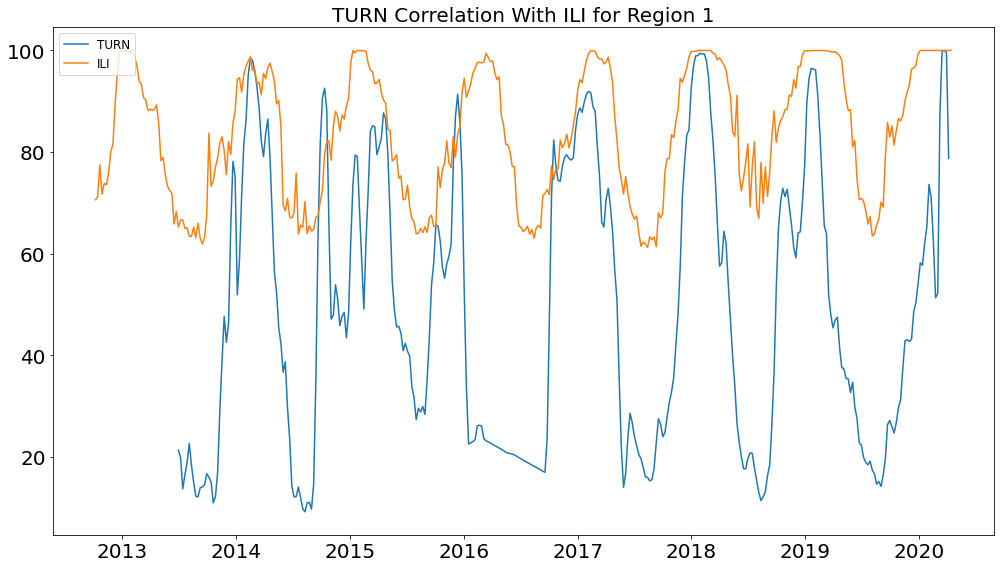

on100         1
on100  1.000000  0.675679
1      0.675679  1.000000

In [ ]:
#plot figure for Region 1
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[1]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion1.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 1', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region1")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion1.on100.to_frame().merge(regionTURN[[1]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region2


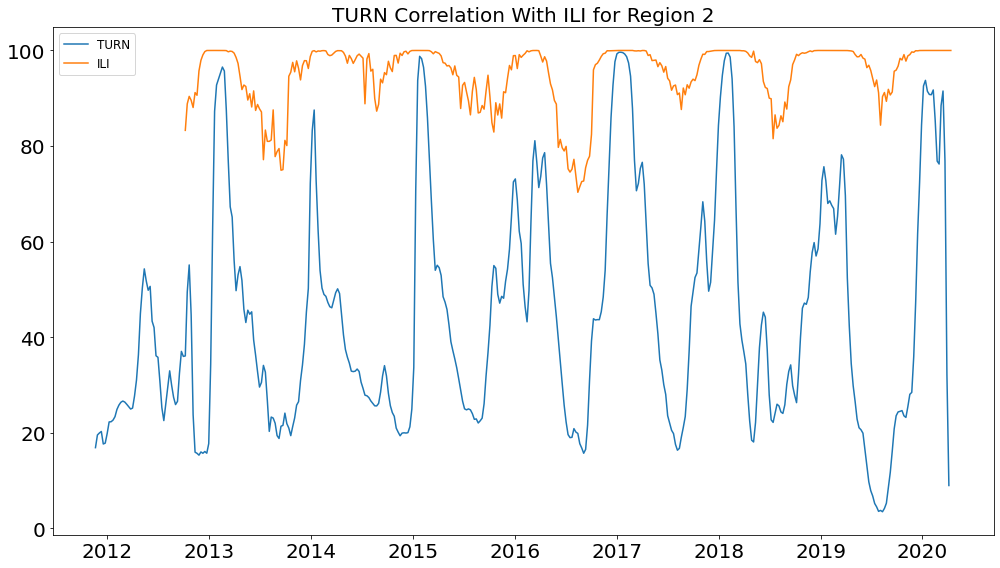

on100         2
on100  1.000000  0.501012
2      0.501012  1.000000

In [ ]:
#plot figure for Region 2
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[2]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion2.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 2', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region2")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion2.on100.to_frame().merge(regionTURN[[2]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region3


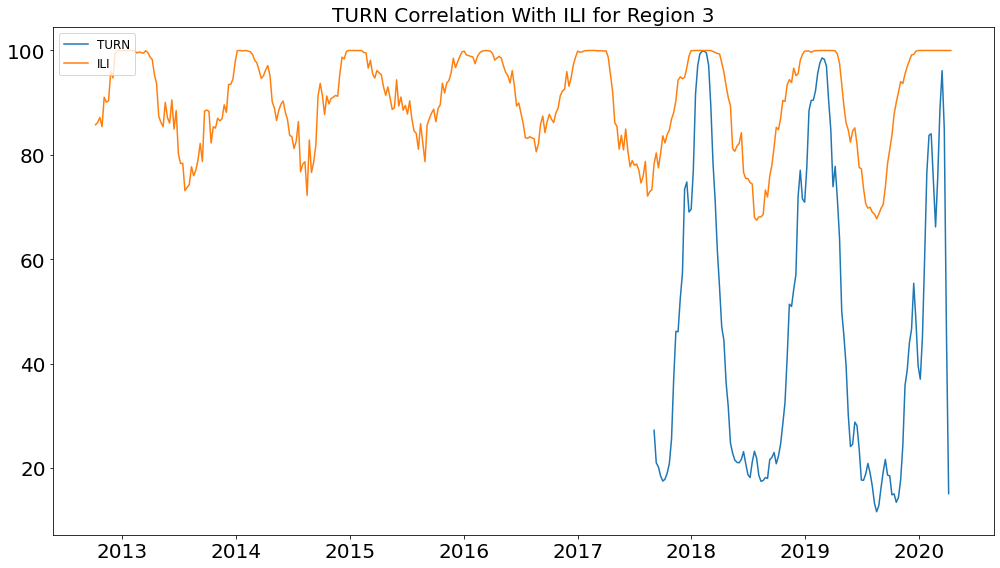

on100         3
on100  1.000000  0.798876
3      0.798876  1.000000

In [ ]:
#plot figure for Region 3
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[3]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion3.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 3', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region3")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion3.on100.to_frame().merge(regionTURN[[3]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region4


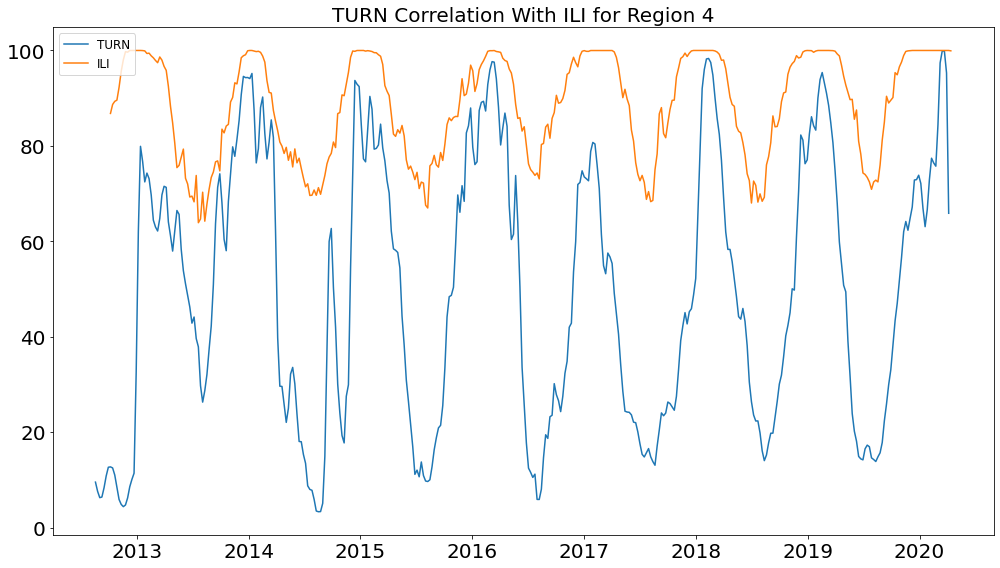

on100         4
on100  1.000000  0.704986
4      0.704986  1.000000

In [ ]:
#plot figure for Region 4
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[4]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion4.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 4', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region4")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion4.on100.to_frame().merge(regionTURN[[4]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region5


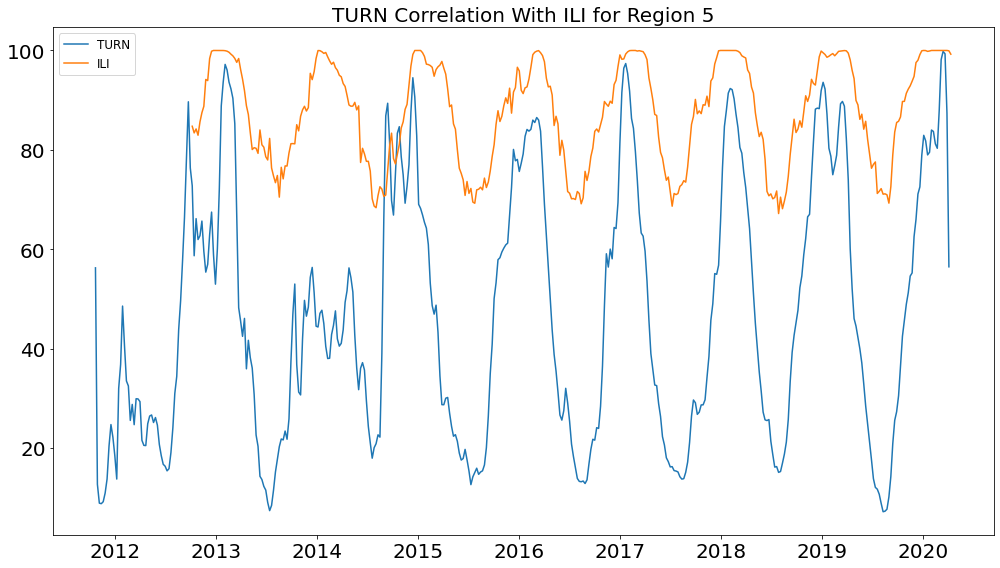

on100         5
on100  1.000000  0.786326
5      0.786326  1.000000

In [ ]:
#plot figure for Region 5
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[5]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion5.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 5', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region5")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion5.on100.to_frame().merge(regionTURN[[5]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region6


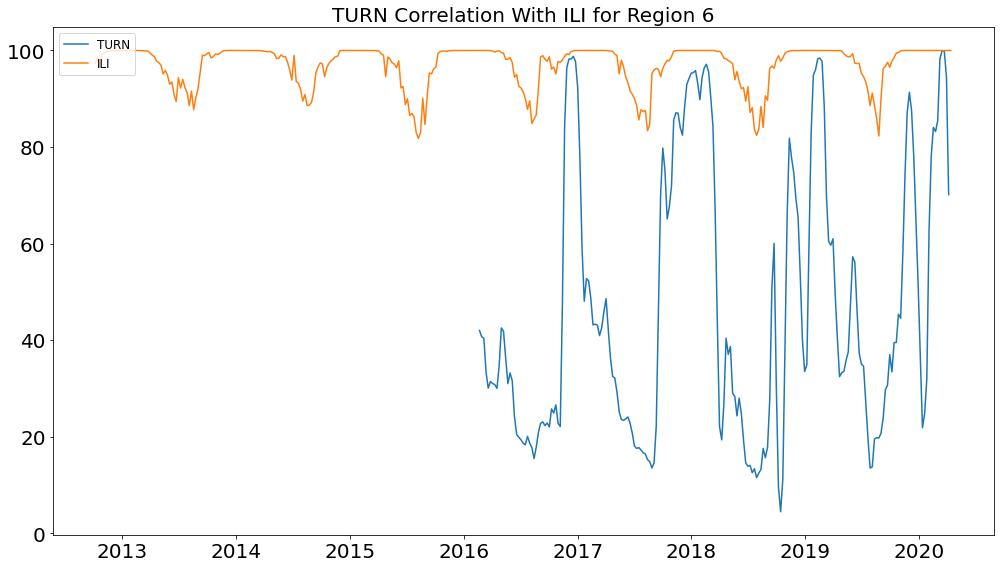

on100         6
on100  1.000000  0.602647
6      0.602647  1.000000

In [ ]:
#plot figure for Region 6
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[6]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion6.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 6', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region6")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion6.on100.to_frame().merge(regionTURN[[6]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region7


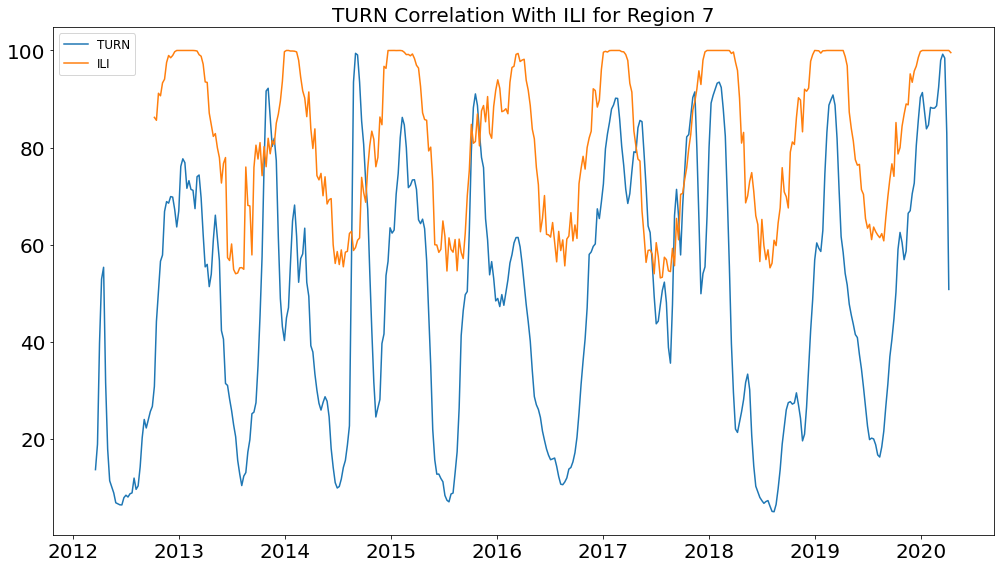

on100         7
on100  1.000000  0.651276
7      0.651276  1.000000

In [ ]:
#plot figure for Region 7
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[7]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion7.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 7', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region7")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion7.on100.to_frame().merge(regionTURN[[7]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region8


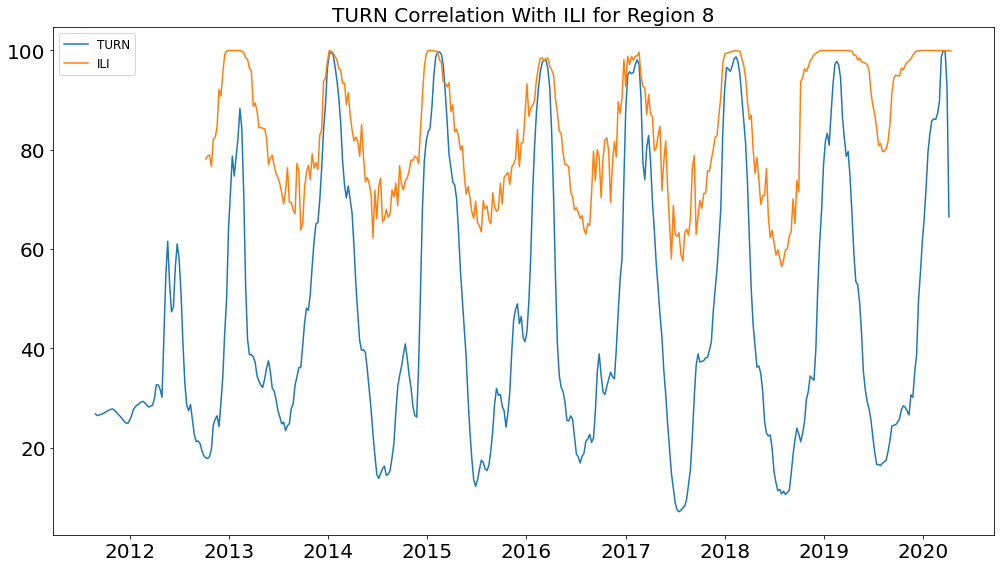

on100         8
on100  1.000000  0.757067
8      0.757067  1.000000

In [ ]:
#plot figure for Region 8
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[8]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion8.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 8', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region8")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion8.on100.to_frame().merge(regionTURN[[8]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region9


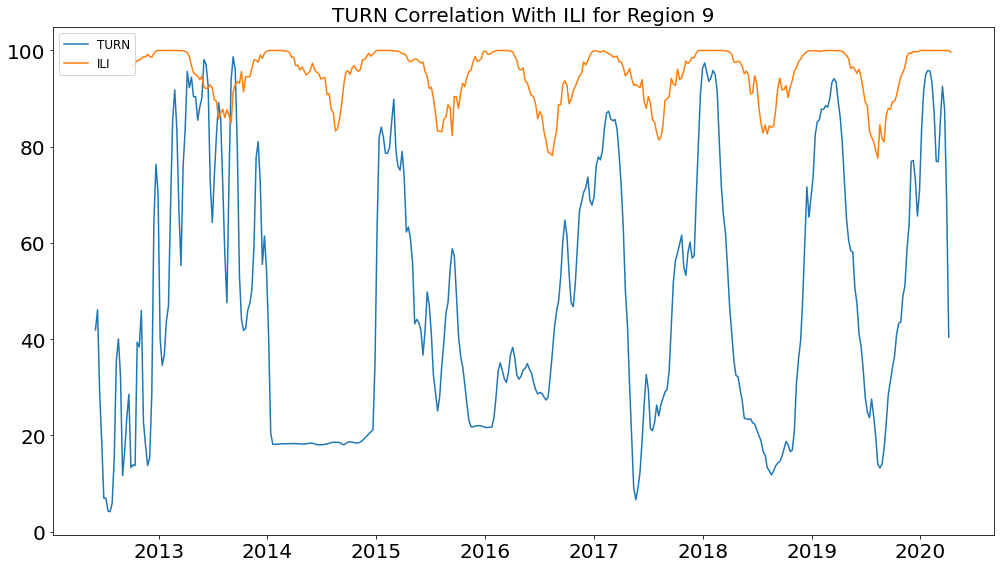

on100         9
on100  1.000000  0.403816
9      0.403816  1.000000

In [ ]:
#plot figure for Region 9
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[9]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion9.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 9', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region9")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion9.on100.to_frame().merge(regionTURN[[9]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()

Saving figure TURN_ILI_Region10


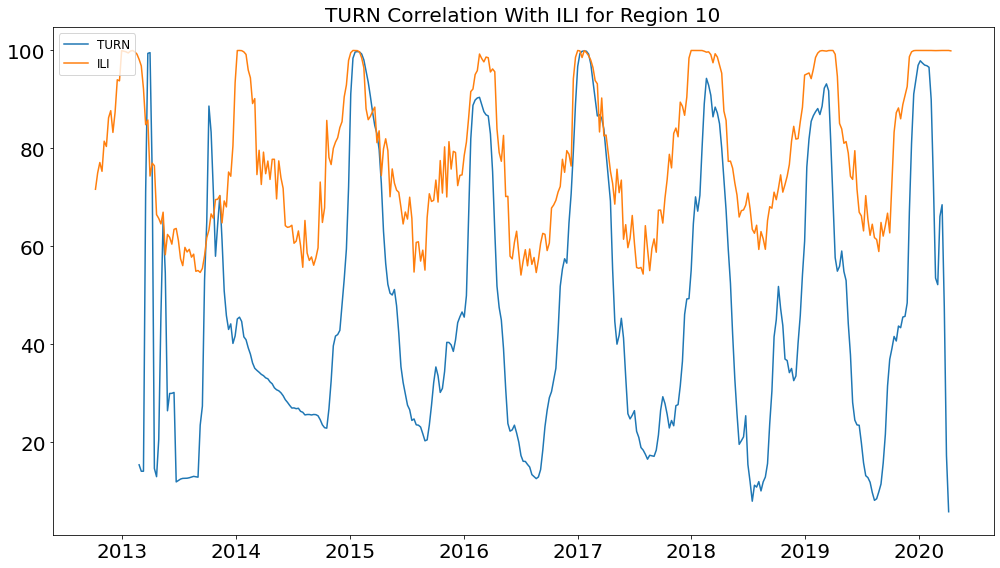

on100        10
on100  1.000000  0.756073
10     0.756073  1.000000

In [ ]:
#plot figure for Region 10
plt.figure(figsize=(14,8))
plt.plot(regionTURN[[10]].resample('W').mean(), label='TURN')
plt.plot(iliDataRegion10.on100, label='ILI')
plt.legend(loc=2)
plt.title('TURN Correlation With ILI for Region 10', fontdict={'fontsize': 20})
save_fig("TURN_ILI_Region10")
plt.show()

# Correlation between ILI and TURN
merged = iliDataRegion10.on100.to_frame().merge(regionTURN[[10]].resample('W').mean(), how='inner', left_index=True, right_index=True)
merged.corr()